In [1]:
import math
#numpy is numerical python, which lets us do math!
import numpy as np
#pandas is for reading in and manipulating dataframe
import pandas as pd
#matplotlib is a plotting library the originated in matlab
from matplotlib import pyplot as plt
#seaborn wraps around matplotlib so that we can make pretty plots more easliy
import seaborn as sns
import missingno as msno
import fancyimpute as fi
#this little line of code lets us see the plots in the notebook
%matplotlib inline
#this uses seaborn (sns) to set the style for all the plots
sns.set(context='poster', style='whitegrid', font_scale=1.4)
from os.path import join
from scipy.stats import ttest_ind, spearmanr, pearsonr, ttest_rel,  wilcoxon, mannwhitneyu
import statsmodels as sm


#less important for plotting
from glob import glob
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.sandbox.stats.multicomp import multipletests
from nilearn.mass_univariate import permuted_ols

Using TensorFlow backend.


In [2]:
import scipy
print(scipy.__version__)
print(sm.version.full_version)

1.2.1
0.9.0


In [3]:
def calculate_pvalues(df, correlation):
    from scipy.stats import pearsonr, pearsonr
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            if correlation == 'pearson':
                pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
            if correlation == 'spearman':
                pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
            else:
                raise ValueError('Invalid correlation method specified. Accpetable values are \'pearson\' and \'spearman\'.')
    return pvalues

In [4]:
#Li & Ji (2005) method for multiple comparisons corrections
#calculating number of effective comparisons M_eff
def liji_sidak_mc(data, alpha):
    import math
    import numpy as np
    
    mc_corrmat = data.corr()
    eigvals, eigvecs = np.linalg.eig(mc_corrmat)

    M_eff = 0
    for eigval in eigvals:
        if abs(eigval) >= 0:
            if abs(eigval) >= 1:
                M_eff += 1
            else:
                M_eff += abs(eigval) - math.floor(abs(eigval))
        else:
            M_eff += 0
    print('Number of effective comparisons: {0}'.format(M_eff))

    #and now applying M_eff to the Sidak procedure
    sidak_p = 1 - (1 - alpha)**(1/M_eff)
    if sidak_p < 0.00001:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:2e} after corrections'.format(sidak_p))
    else:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:.6f} after corrections'.format(sidak_p))
    return sidak_p, M_eff

In [5]:
#reading in and rearranging data
data_dir = '/Users/Katie/Dropbox/Projects/physics-retrieval/data'
fig_dir = '/Users/Katie/Dropbox/Projects/physics-retrieval/figures'

demo_df = pd.read_csv(join(data_dir, 'c123456_FullDemographics.csv'), encoding='iso-8859-1', 
                      index_col=0, header=0, skipfooter=1, engine='python')
iq_df = pd.read_csv(join(data_dir, 'wais-iv_rescored.csv'), index_col=0, header=0)


In [6]:
demo_df[demo_df['Strt.Level'] < 0] = np.nan

In [7]:
post_phy_rt_df = pd.read_csv(join(data_dir, 'retr_physcond_accuracy_by_gender_post.txt'), sep='\t', index_col=1)
post_phy_rt_df.rename({'Mean Physics Retrieval Accuracy': 'RetrPhyAcc2'}, axis='columns', inplace=True)
post_phy_rt_df.rename({'Mean Correct RT': 'Mean Correct RT Post',
                      'Mean Incorrect RT': 'Mean Incorrect RT Post'}, axis=1, inplace=True)

pre_phy_rt_df = pd.read_csv(join(data_dir, 'retr_physcond_accuracy_by_gender_pre.txt'), sep='\t', index_col=1)
pre_phy_rt_df.rename({'Mean Physics Retrieval Accuracy': 'RetrPhyAcc1'},axis='columns', inplace=True)
pre_phy_rt_df.drop('Class', axis=1, inplace=True)
pre_phy_rt_df.drop('Gender', axis=1, inplace=True)
pre_phy_rt_df.rename({'Mean Correct RT': 'Mean Correct RT Pre',
                      'Mean Incorrect RT': 'Mean Incorrect RT Pre'}, axis=1, inplace=True)

phy_rt_df = pd.concat((pre_phy_rt_df, post_phy_rt_df), axis=1)
#phy_rt_df.rename({'Mean Correct RT': 'Mean Correct Physics RT',
#                  'Mean Incorrect RT': 'Mean Incorrect Physics RT'}, axis=1, inplace=True)

In [8]:
fci_bx_df = pd.read_csv(join(data_dir, 'fci_accuracy_rt.txt'), sep='\t', index_col=[0,1], header=0)
fci_bx_pre = pd.Series(fci_bx_df.xs('session-0', level='Session')['Mean FCI Accuracy'], name='FCIPhyAcc1')
fci_bx_post = pd.Series(fci_bx_df.xs('session-1', level='Session')['Mean FCI Accuracy'], name='FCIPhyAcc2')

In [9]:
#iq = pd.read_excel('/Users/Katie/Dropbox/Physics Learning/Physics learning_Full Scale IQ.xlsx', index_col=0, header=0)
pre_iq = ['VCI1', 'PRI1', 'WMI1', 'PSI1', 'FSIQ1']
post_iq = ['VCI2', 'PRI2', 'WMI2', 'PSI2', 'FSIQ2']
iq_vars = pre_iq + post_iq
iqs = ['VCI', 'PRI', 'WMI', 'PSI', 'FSIQ']
drop = set(iq_df.keys()) - set(iq_vars)
iq_df.drop(drop, axis=1, inplace=True)

In [24]:
subjects = iq_df.index.values

In [11]:
all_df = pd.concat([demo_df, phy_rt_df, fci_bx_pre, fci_bx_post, iq_df], axis=1)
#all_df = pd.concat([all_df, ], axis=1)
all_df.replace({'Lect': 'Lec'}, inplace=True)

In [12]:
all_df['deltaRetrPhyAcc'] = all_df['RetrPhyAcc2'] - all_df['RetrPhyAcc1']
all_df['deltaFCIPhyAcc'] = all_df['FCIPhyAcc2'] - all_df['FCIPhyAcc1']
all_df['deltaVCI'] = all_df['VCI2'] - all_df['VCI1']
all_df['deltaPRI'] = all_df['PRI2'] - all_df['PRI1']
all_df['deltaWMI'] = all_df['WMI2'] - all_df['WMI1']
all_df['deltaPSI'] = all_df['PSI2'] - all_df['PSI1']
all_df['deltaFSIQ'] = all_df['FSIQ2'] - all_df['FSIQ1']

In [13]:
all_df.drop(['Section', 'Score', 'Test.ID', 'Component',
             'Acad.Plan', 'Study.Cmplt', 'Mean Incorrect RT Pre', 'Mean Incorrect RT Post',
             'Gender', 'Class', 'index', 'Gender And Class', 'Session'], axis=1, inplace=True)

In [14]:
all_df.keys()

Index(['Class.Type', 'Sex', 'Ethnic.Grp', 'GPA', 'Age', 'Handedness',
       'Strt.Level', 'RetrPhyAcc1', 'Mean Correct RT Pre', 'RetrPhyAcc2',
       'Mean Correct RT Post', 'FCIPhyAcc1', 'FCIPhyAcc2', 'VCI1', 'PRI1',
       'WMI1', 'PSI1', 'FSIQ1', 'VCI2', 'PRI2', 'WMI2', 'PSI2', 'FSIQ2',
       'deltaRetrPhyAcc', 'deltaFCIPhyAcc', 'deltaVCI', 'deltaPRI', 'deltaWMI',
       'deltaPSI', 'deltaFSIQ'],
      dtype='object')

In [15]:
df_f = all_df[all_df['Sex'] == 'F']
df_f = df_f.drop('Sex', axis=1)
df_m = all_df[all_df['Sex'] == 'M']
df_m = df_m.drop('Sex', axis=1)

df_f['const'] = 1
df_m['const'] = 1

# Assessing the shape of the data
Can we use parametric tests? Do we have to switch to nonparametric?

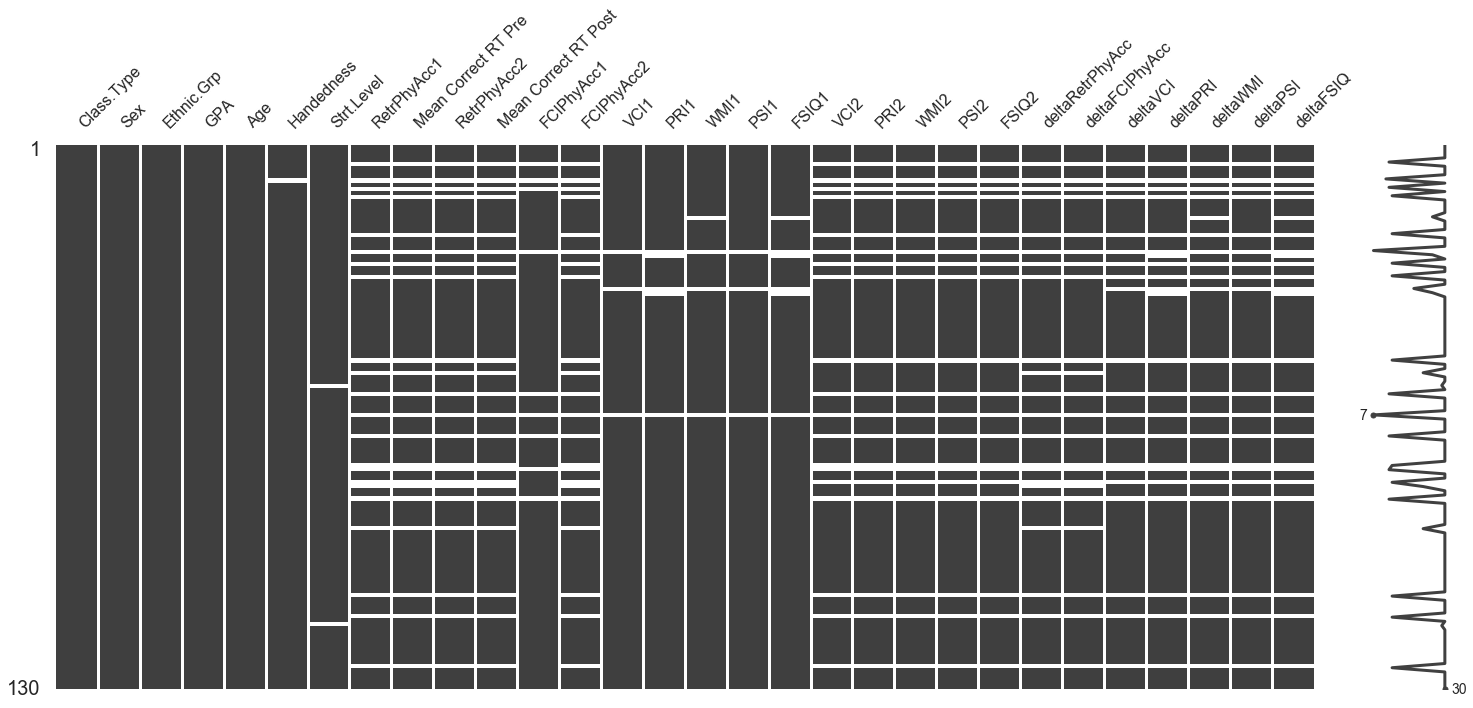

In [16]:
msno.matrix(all_df)

In [33]:
missing_IQ = [] 
for subject in subjects:
    if np.isnan(all_df.loc[subject]['FSIQ2']):
        print(subject)
        if np.isnan(all_df.loc[subject]['FSIQ1']):
            print(subject)
            missing_IQ.append(subject)
        else: pass

326
326
575
576
322
583
611
501
332
329
461
579
211
213
616
109
452
628
105


In [34]:
missing_IQ

[326]

In [19]:
for key in all_df.keys():
    print(key, 1- (all_df[key].dropna().shape[0]/130))

Class.Type 0.0
Sex 0.0
Ethnic.Grp 0.0
GPA 0.0
Age 0.0
Handedness 0.007692307692307665
Strt.Level 0.01538461538461533
RetrPhyAcc1 0.16923076923076918
Mean Correct RT Pre 0.16923076923076918
RetrPhyAcc2 0.16923076923076918
Mean Correct RT Post 0.16923076923076918
FCIPhyAcc1 0.0692307692307692
FCIPhyAcc2 0.16923076923076918
VCI1 0.023076923076923106
PRI1 0.038461538461538436
WMI1 0.03076923076923077
PSI1 0.023076923076923106
FSIQ1 0.0461538461538461
VCI2 0.1461538461538462
PRI2 0.1461538461538462
WMI2 0.1461538461538462
PSI2 0.1461538461538462
FSIQ2 0.1461538461538462
deltaRetrPhyAcc 0.16923076923076918
deltaFCIPhyAcc 0.16923076923076918
deltaVCI 0.15384615384615385
deltaPRI 0.16923076923076918
deltaWMI 0.16153846153846152
deltaPSI 0.15384615384615385
deltaFSIQ 0.17692307692307696


In [20]:
missing_df = pd.DataFrame(columns=all_df.keys(), index=all_df.index)

for key in missing_df.keys():
    missing_df[key] = all_df[key].isnull()

missing_df.replace({False: 0, True:1}, inplace=True)

for key1 in missing_df.keys():
    try:
        corr,pval = pearsonr(missing_df[key1], all_df[key1])
        if pval < 0.05:
            print(key1, corr, pval)
    except:
        pass
    for key2 in all_df.keys():
        try:
            corr,pval = pearsonr(missing_df[key1], all_df[key2])
            if pval < 0.05:
                print(key1, key2, corr, pval)
        except Exception as e:
            pass

Strt.Level Age -0.5788577495018394 5.443947292273025e-13


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [35]:
impute_pls = fi.SoftImpute(max_iters=10000, verbose=False, )

all_imputed = impute_pls.fit_transform(all_df.drop(['Class.Type', 'Sex', 'Ethnic.Grp'], axis=1))

In [36]:
imputed_df = pd.DataFrame(all_imputed, 
                          columns=all_df.drop(['Class.Type', 'Sex', 'Ethnic.Grp'], axis=1).columns, 
                          index=all_df.index)

In [37]:
imputed_df['Sex'] = all_df['Sex']
imputed_df['Ethnic.Grp'] = all_df['Ethnic.Grp']
imputed_df['Class.Type'] = all_df['Class.Type']

In [52]:
imputed_df.min()

GPA                               0
Age                               0
Handedness                0.0550177
Strt.Level                       10
RetrPhyAcc1             0.000775527
Mean Correct RT Pre          5.0738
RetrPhyAcc2             0.000884069
Mean Correct RT Post        4.93728
FCIPhyAcc1                        0
FCIPhyAcc2              0.000707567
VCI1                       0.125424
PRI1                        0.12469
WMI1                       0.120543
PSI1                       0.115728
FSIQ1                      0.122906
VCI2                       0.126774
PRI2                       0.130592
WMI2                       0.121368
PSI2                       0.128886
FSIQ2                      0.129716
deltaRetrPhyAcc               -0.25
deltaFCIPhyAcc            -0.555556
deltaVCI                        -32
deltaPRI                        -21
deltaWMI                        -31
deltaPSI                        -25
deltaFSIQ                       -14
Sex                         

In [39]:
np.sum(all_df.isna().values)

0

In [40]:
kurtosis = all_df.kurtosis(axis=0, skipna=True)
mean = all_df.mean(axis=0, skipna=True)
skew = all_df.skew(axis=0, skipna=True)
median = all_df.median(axis=0, skipna=True)
stdev = all_df.std(axis=0, skipna=True)
descriptives = pd.concat([mean, stdev, median, skew, kurtosis], axis=1)
descriptives.rename(columns={0: 'Mean', 1: 'StDev', 2: 'Median', 3: 'Skew', 4: 'Kurtosis'}, inplace=True)
descriptives.to_csv('{0}/descriptives.csv'.format(data_dir), sep=',')
descriptives

,Mean,StDev,Median,Skew,Kurtosis
GPA,2.970077,1.043979,3.230000,-1.822938,2.983929
Age,20.034963,2.248706,19.941096,-5.152914,49.079155
Handedness,0.853500,0.181144,0.900000,-1.650072,3.808864
Strt.Level,24.872896,7.989968,20.000000,0.182358,-0.408298
RetrPhyAcc1,0.565913,0.263835,0.625000,-1.083754,-0.028933
Mean Correct RT Pre,3640.756881,1565.389924,4233.541667,-1.556766,0.813338
RetrPhyAcc2,0.644174,0.290830,0.750000,-1.274506,0.265783
Mean Correct RT Post,3538.318886,1530.220778,4132.546218,-1.522021,0.757581
FCIPhyAcc1,0.426382,0.238250,0.444444,0.141078,-0.454586
FCIPhyAcc2,0.515410,0.282742,0.555556,-0.440148,-0.888519


In [41]:
kurtosis = df_f.kurtosis(axis=0, skipna=True)
mean = df_f.mean(axis=0, skipna=True)
skew = df_f.skew(axis=0, skipna=True)
median = df_f.median(axis=0, skipna=True)
stdev = df_f.std(axis=0, skipna=True)
descriptives_f = pd.concat([mean, stdev, median, skew, kurtosis], axis=1)
descriptives_f.rename(columns={0: 'Mean', 1: 'StDev', 2: 'Median', 3: 'Skew', 4: 'Kurtosis'}, inplace=True)
descriptives_f.to_csv('{0}/descriptives_f.csv'.format(data_dir), sep=',')

kurtosis = df_m.kurtosis(axis=0, skipna=True)
mean = df_m.mean(axis=0, skipna=True)
skew = df_m.skew(axis=0, skipna=True)
median = df_m.median(axis=0, skipna=True)
stdev = df_m.std(axis=0, skipna=True)
descriptives_m = pd.concat([mean, stdev, median, skew, kurtosis], axis=1)
descriptives_m.rename(columns={0: 'Mean', 1: 'StDev', 2: 'Median', 3: 'Skew', 4: 'Kurtosis'}, inplace=True)
descriptives_m.to_csv('{0}/descriptives_m.csv'.format(data_dir), sep=',')

In [42]:
descriptives_f

,Mean,StDev,Median,Skew,Kurtosis
GPA,3.021639,0.986633,3.230000,-1.825973,3.589479
Age,19.910712,2.930143,20.005479,-5.203871,36.475151
Handedness,0.895082,0.141923,1.000000,-1.321100,1.057922
Strt.Level,26.500000,7.988339,30.000000,-0.099575,-0.376852
RetrPhyAcc1,0.615451,0.144399,0.625000,0.076628,-0.401106
Mean Correct RT Pre,4372.112357,432.315249,4427.757212,-0.251900,0.379821
RetrPhyAcc2,0.717014,0.113365,0.708333,-0.566478,0.643660
Mean Correct RT Post,4321.633837,431.224666,4331.781250,0.000626,-0.144100
FCIPhyAcc1,0.345454,0.190867,0.333333,0.848389,1.767041
FCIPhyAcc2,0.523148,0.197114,0.555556,0.320580,0.435828


In [43]:
short_iqs = ['PRIQ', 'PSIQ', 'VCIQ', 'WMIQ', 'FSIQ']

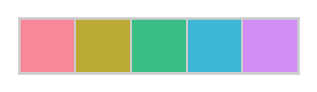

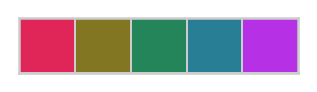

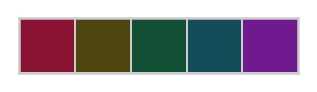

In [44]:
light_hsl = sns.husl_palette(n_colors=5, s=0.9, l=0.7)
dark_hsl = sns.husl_palette(n_colors=5, s=0.9, l=0.5)
darker_hsl = sns.husl_palette(n_colors=5, s=0.9, l=0.3)
sns.palplot(light_hsl)
sns.palplot(dark_hsl)
sns.palplot(darker_hsl)

In [45]:
print(iqs)

['VCI', 'PRI', 'WMI', 'PSI', 'FSIQ']


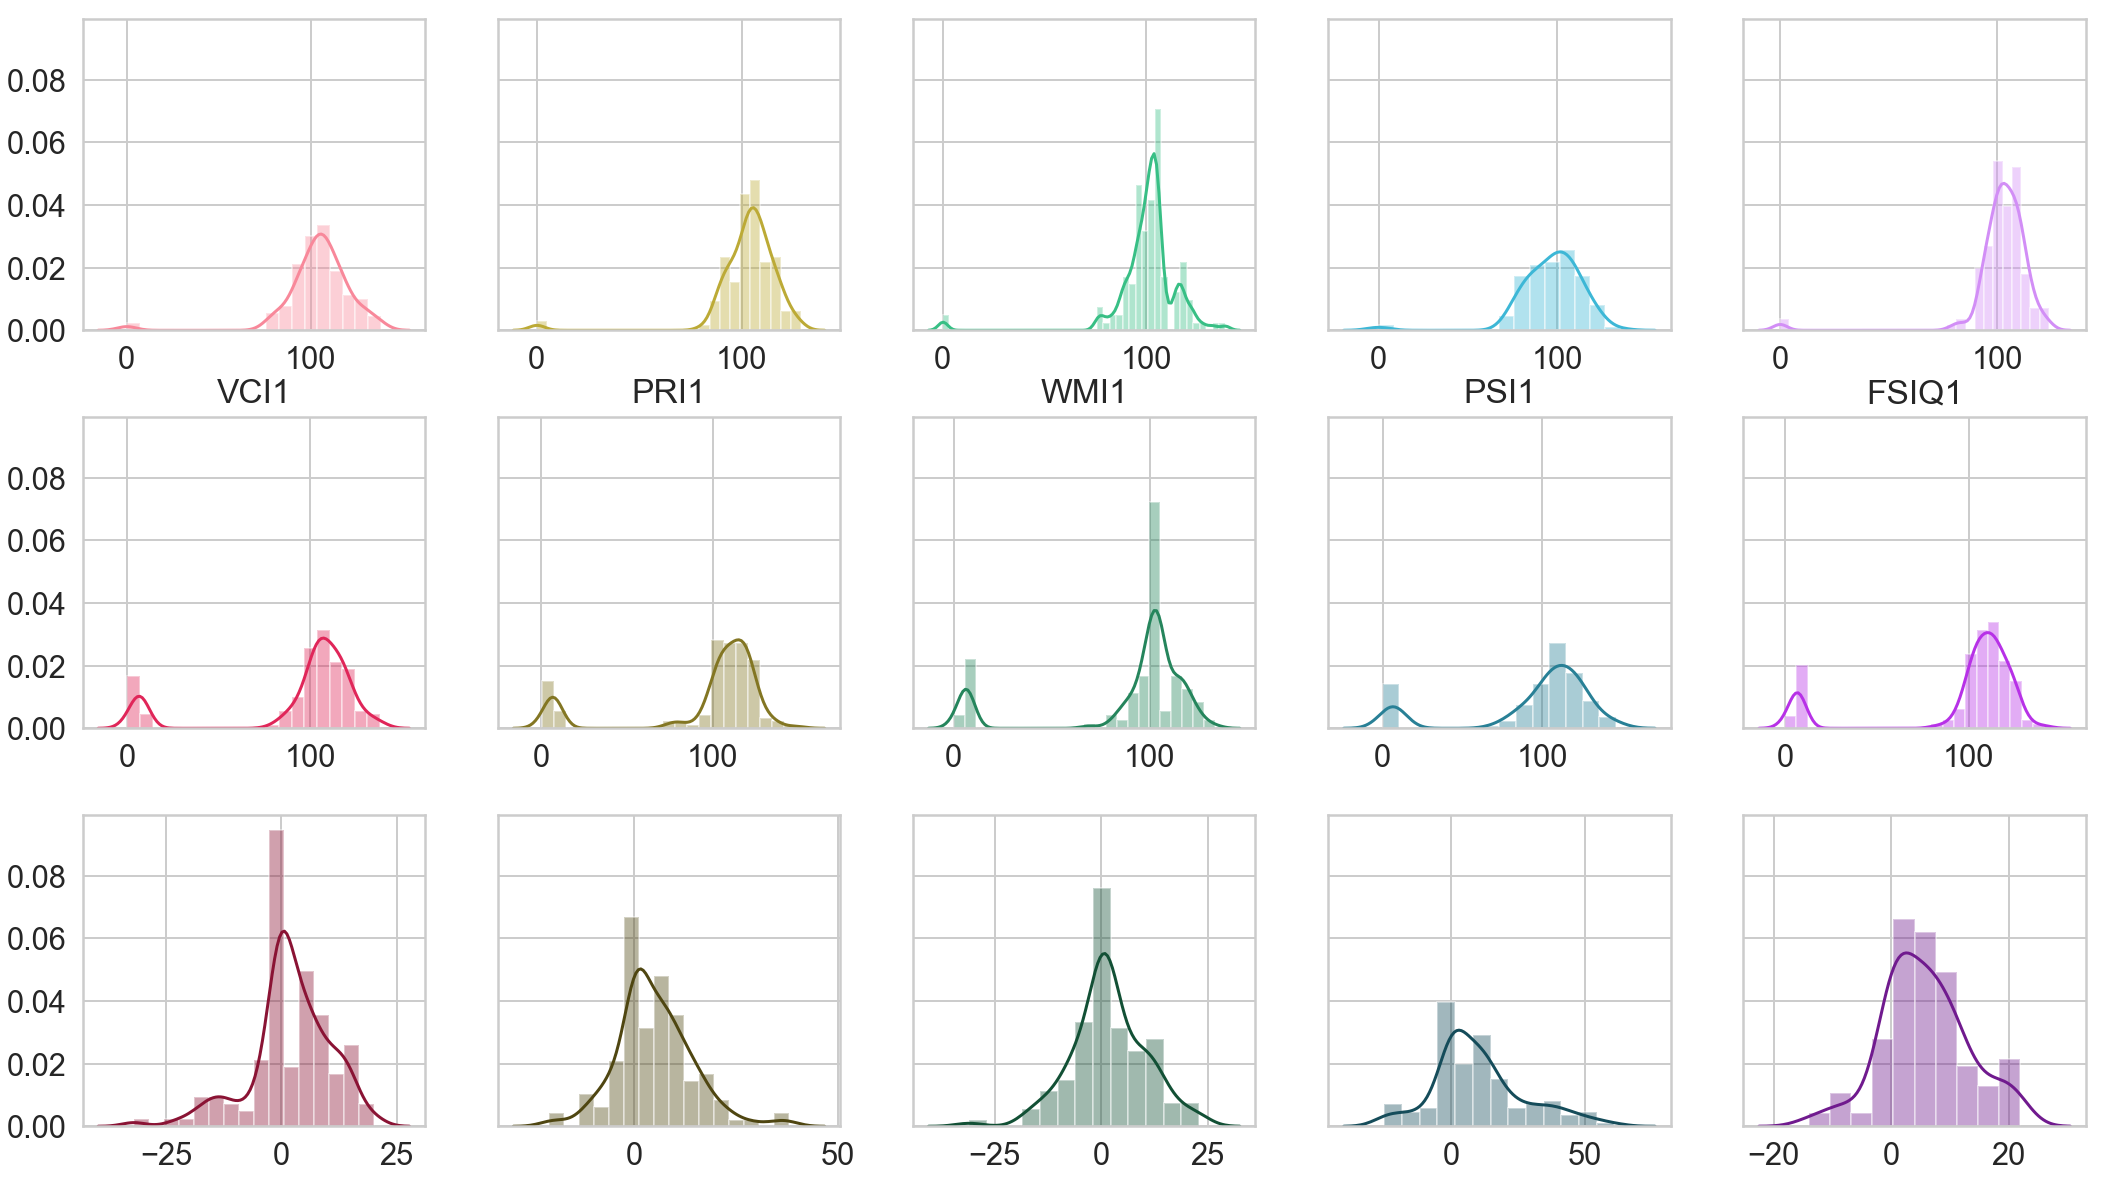

In [46]:
fig,ax = plt.subplots(nrows=3, ncols=5, sharey=True, figsize=(30, 17))
plt.tight_layout(pad=3)

for i in np.arange(0,len(iqs)):
    g = sns.distplot(all_df['{0}1'.format(iqs[i])].dropna(), ax=ax[0][i], color=light_hsl[i])
    g.set_xlabel('{0}1'.format(iqs[i]))
    h = sns.distplot(all_df['{0}2'.format(iqs[i])].dropna(), ax=ax[1][i], color=dark_hsl[i])
    h.set_xlabel('')
    j = sns.distplot(all_df['delta{0}'.format(iqs[i])].dropna(), ax=ax[2][i], color=darker_hsl[i])
    j.set_xlabel('')
fig.savefig(join(fig_dir, 'SI1_distpng'), dpi=300)

In [47]:
#more data wrangling, for figure creation
all_df['Subject'] = all_df.index
pr_long = all_df.melt(id_vars=['Sex', 'Subject', 'Class.Type'], value_vars=['PRI1', 'PRI2'],
                 var_name='Session')
pr_long.replace(to_replace='PRI1', value='Pre', inplace=True)
pr_long.replace(to_replace='PRI2', value='Post', inplace=True)

vc_long = all_df.melt(id_vars=['Sex', 'Subject', 'Class.Type'], value_vars=['VCI1', 'VCI2'],
                 var_name='Session')
vc_long.replace(to_replace='VCI1', value='Pre', inplace=True)
vc_long.replace(to_replace='VCI2', value='Post', inplace=True)


wm_long = all_df.melt(id_vars=['Sex', 'Subject', 'Class.Type'], value_vars=['WMI1', 'WMI2'],
                 var_name='Session')
wm_long.replace(to_replace='WMI1', value='Pre', inplace=True)
wm_long.replace(to_replace='WMI2', value='Post', inplace=True)

ps_long = all_df.melt(id_vars=['Sex', 'Subject', 'Class.Type'], value_vars=['PSI1', 'PSI2'],
                 var_name='Session')
ps_long.replace(to_replace='PSI1', value='Pre', inplace=True)
ps_long.replace(to_replace='PSI2', value='Post', inplace=True)

fs_long = all_df.melt(id_vars=['Sex', 'Subject', 'Class.Type'], value_vars=['FSIQ1', 'FSIQ2'],
                 var_name='Session')
fs_long.replace(to_replace='FSIQ1', value='Pre', inplace=True)
fs_long.replace(to_replace='FSIQ2', value='Post', inplace=True)


In [48]:
pr_long['IQ'] = 'Perceptual Reasoning'
vc_long['IQ'] = 'Verbal Comprehension'
wm_long['IQ'] = 'Working Memory'
ps_long['IQ'] = 'Processing Speed'
fs_long['IQ'] = 'Full Scale IQ'

all_iq_long = pd.concat([pr_long, vc_long, wm_long, ps_long, fs_long], axis=0)
pr_long.rename({'value': 'Perceptual Reasoning'}, axis=1, inplace=True)
vc_long.rename({'value': 'Verbal Comprehension'}, axis=1, inplace=True)
wm_long.rename({'value': 'Working Memory'}, axis=1, inplace=True)
ps_long.rename({'value': 'Processing Speed'}, axis=1, inplace=True)
fs_long.rename({'value': 'Full Scale IQ'}, axis=1, inplace=True)

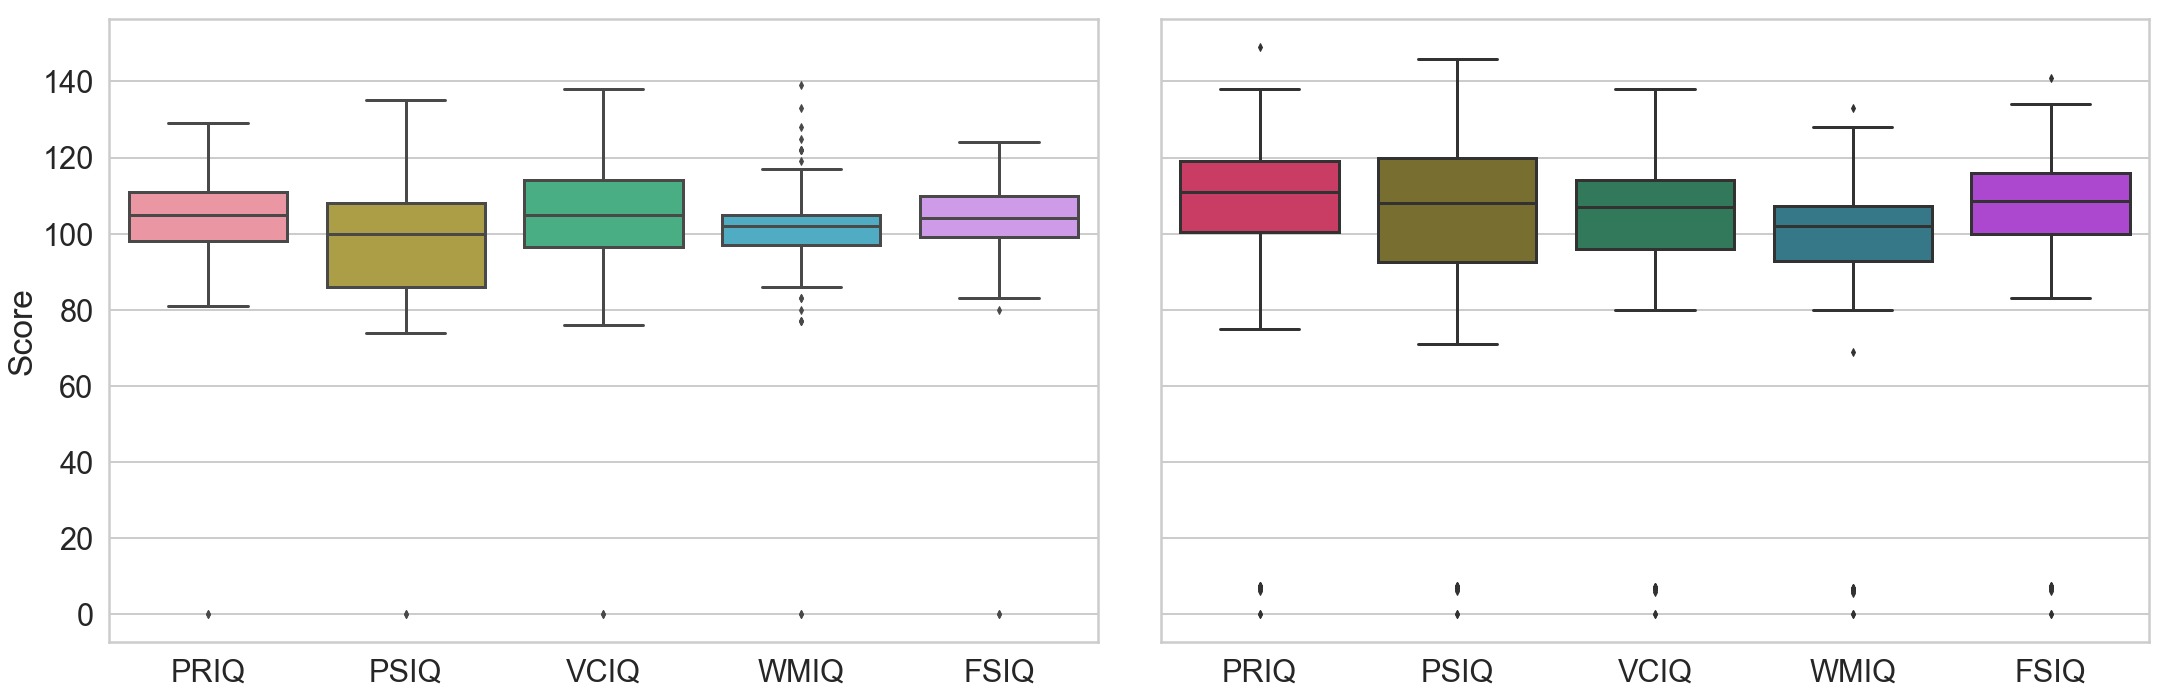

In [49]:
fig,ax = plt.subplots(ncols=2, sharey=True, figsize=(30, 10))
plt.tight_layout(pad=2)
h = sns.boxplot(x='IQ', y='value', data=all_iq_long[all_iq_long['Session'] == 'Post'], 
                order=['Perceptual Reasoning', 'Processing Speed', 'Verbal Comprehension',
                       'Working Memory', 'Full Scale IQ'], 
                ax=ax[1], palette=dark_hsl)
g = sns.boxplot(x='IQ', y='value', data=all_iq_long[all_iq_long['Session'] == 'Pre'], 
                order=['Perceptual Reasoning', 'Processing Speed', 'Verbal Comprehension',
                       'Working Memory', 'Full Scale IQ'], 
                ax=ax[0], palette=light_hsl)
g.set_xticklabels(['PRIQ', 'PSIQ', 'VCIQ', 'WMIQ', 'FSIQ'])
h.set_xticklabels(['PRIQ', 'PSIQ', 'VCIQ', 'WMIQ', 'FSIQ'])
g.set_xlabel('')
h.set_xlabel('')
g.set_ylabel('Score')
h.set_ylabel('')
fig.savefig(join(fig_dir, 'SI1_boxpng'), dpi=300)

In [41]:
all_df.keys()

Index(['GPA', 'Age', 'Handedness', 'Strt.Level', 'RetrPhyAcc1',
       'Mean Correct RT Pre', 'RetrPhyAcc2', 'Mean Correct RT Post',
       'FCIPhyAcc1', 'FCIPhyAcc2', 'VCI1', 'PRI1', 'WMI1', 'PSI1', 'FSIQ1',
       'VCI2', 'PRI2', 'WMI2', 'PSI2', 'FSIQ2', 'deltaRetrPhyAcc',
       'deltaFCIPhyAcc', 'deltaVCI', 'deltaPRI', 'deltaWMI', 'deltaPSI',
       'deltaFSIQ', 'Sex', 'Ethnic.Grp', 'Class.Type', 'Subject'],
      dtype='object')

## Does IQ significantly change over the course of the semester for all students?

In [42]:
mc_alpha,_ = liji_sidak_mc(all_df[['PRI1', 'WMI1',
                                   'PSI1', 'FSIQ1',
                                   'VCI2', 'PRI2',
                                   'WMI2', 'PSI2', 'FSIQ2',
                                   'deltaVCI', 'deltaPRI',
                                   'deltaWMI', 'deltaPSI', 'deltaFSIQ']], 
                           0.001)

Number of effective comparisons: 6.567473834226289
Critical value of 0.001 becomes 0.000152 after corrections


In [43]:
coursetype = ['All', 'Modeling', 'Lecture']

delta_tests = pd.DataFrame(index=pd.MultiIndex.from_product((iqs, coursetype)), 
                           columns=['delta', 'sdev(delta)', 't(delta)', 'p(t)', 'w+', 'p(w+)'])
for i in iqs:
    delta_iq = ttest_rel(all_df['{0}2'.format(i)], all_df['{0}1'.format(i)], nan_policy='omit')
    delta_tests.at[(i, 'All'), 'delta'] = np.average(all_df['{0}2'.format(i)].dropna())-np.average(all_df['{0}1'.format(i)].dropna())
    delta_tests.at[(i, 'All'), 't(delta)'] = delta_iq.statistic
    delta_tests.at[(i, 'All'), 'p(t)'] = delta_iq.pvalue

    delta_tests.at[(i, 'All'), 'sdev(delta)'] = np.std(all_df['delta{0}'.format(i)])
    delta_tests.at[(i, 'Modeling'), 'sdev(delta)'] = np.std(all_df[all_df['Class.Type'] == 'Mod']['delta{0}'.format(i)])
    delta_tests.at[(i, 'Lecture'), 'sdev(delta)'] = np.std(all_df[all_df['Class.Type'] == 'Lec']['delta{0}'.format(i)])

    delta_iq = ttest_rel(all_df[all_df['Class.Type'] == 'Mod']['{0}2'.format(i)], all_df[all_df['Class.Type'] == 'Mod']['{0}1'.format(i)], nan_policy='omit')
    delta_tests.at[(i, 'Modeling'), 'delta'] = np.average(all_df[all_df['Class.Type'] == 'Mod']['{0}2'.format(i)].dropna())-np.average(all_df[all_df['Class.Type'] == 'Mod']['{0}1'.format(i)].dropna())
    delta_tests.at[(i, 'Modeling'), 't(delta)'] = delta_iq.statistic
    delta_tests.at[(i, 'Modeling'), 'p(t)'] = delta_iq.pvalue
    
    delta_iq = ttest_rel(all_df[all_df['Class.Type'] == 'Lec']['{0}2'.format(i)], all_df[all_df['Class.Type'] == 'Lec']['{0}1'.format(i)], nan_policy='omit')
    delta_tests.at[(i, 'Lecture'), 'delta'] = np.average(all_df[all_df['Class.Type'] == 'Lec']['{0}2'.format(i)].dropna())-np.average(all_df[all_df['Class.Type'] == 'Lec']['{0}1'.format(i)].dropna())
    delta_tests.at[(i, 'Lecture'), 't(delta)'] = delta_iq.statistic
    delta_tests.at[(i, 'Lecture'), 'p(t)'] = delta_iq.pvalue
    

    
    delta_iq = wilcoxon(all_df['{0}2'.format(i)], all_df['{0}1'.format(i)])
    delta_tests.at[(i, 'All'), 'w+'] = delta_iq.statistic
    delta_tests.at[(i, 'All'), 'p(w+)'] = delta_iq.pvalue
    
    delta_iq = wilcoxon(all_df[all_df['Class.Type'] == 'Mod']['{0}2'.format(i)], all_df[all_df['Class.Type'] == 'Mod']['{0}1'.format(i)])
    delta_tests.at[(i, 'Modeling'), 'w+'] = delta_iq.statistic
    delta_tests.at[(i, 'Modeling'), 'p(w+)'] = delta_iq.pvalue
    
    delta_iq = wilcoxon(all_df[all_df['Class.Type'] == 'Lec']['{0}2'.format(i)], all_df[all_df['Class.Type'] == 'Lec']['{0}1'.format(i)])
    delta_tests.at[(i, 'Lecture'), 'w+'] = delta_iq.statistic
    delta_tests.at[(i, 'Lecture'), 'p(w+)'] = delta_iq.pvalue
    
        
delta_tests.to_csv(join(data_dir, 'change-in-iq.csv'))

In [44]:
delta_tests

delta sdev(delta)  t(delta)         p(t)      w+  \
VCI  All        -10.591     8.75304  -3.53152  0.000573732  3457.5   
     Modeling  -5.09683     7.70597  -1.48217     0.143281     755   
     Lecture   -15.9186     9.63744  -3.30799   0.00153419   687.5   
PRI  All       -6.90987     9.33691  -2.22791    0.0276189  3002.5   
     Modeling  -1.31878     8.90356 -0.358578     0.721109     570   
     Lecture   -12.3315     9.70376  -2.51866    0.0142504     927   
WMI  All       -11.1287     8.75385  -3.65317  0.000375403  3088.5   
     Modeling  -6.32926     9.02788  -1.77737    0.0803337   738.5   
     Lecture   -15.7826      8.4756  -3.24324   0.00186723     801   
PSI  All       -1.61316      16.965 -0.476791     0.634318    2740   
     Modeling    7.7508     17.5492   1.91489    0.0600499     419   
     Lecture   -10.6934     15.2913  -2.06663    0.0427573     836   
FSIQ All       -6.40192     7.31955  -2.07385    0.0400825    2762   
     Modeling  0.366095     6.47288  0.101825     0.919219     355   
     Lecture   -12.9648      7.8147  -2.65998   0.00983116    1030   

                     p(w+)  
VCI  All          0.886775  
     Modeling     0.238596  
     Lecture      0.193196  
PRI  All         0.0406734  
     Modeling   0.00433373  
     Lecture      0.894246  
WMI  All          0.323163  
     Modeling     0.972499  
     Lecture      0.156171  
PSI  All         0.0197448  
     Modeling  0.000155398  
     Lecture      0.711431  
FSIQ All        0.00172611  
     Modeling  1.30385e-05  
     Lecture      0.781145

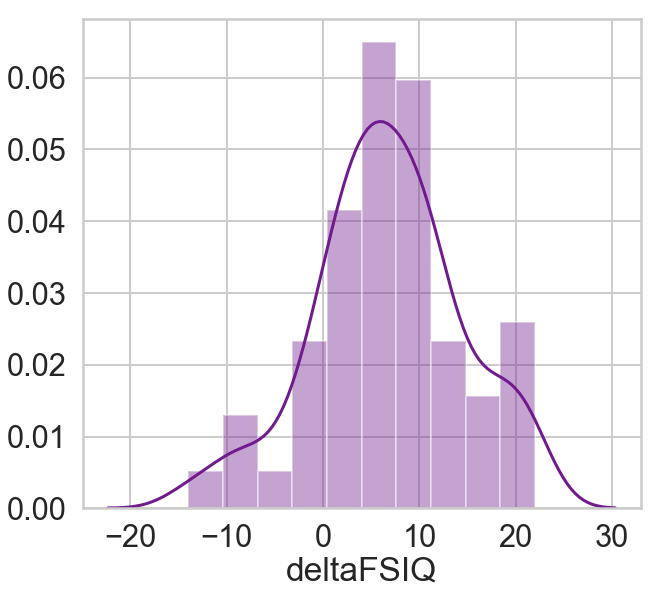

In [43]:
fig,ax = plt.subplots(figsize=(10,9))
sns.distplot(all_df['deltaFSIQ'].dropna(), color=darker_hsl[4])
fig.savefig(join(fig_dir, 'SI-1_fsiqpng'), dpi=300)

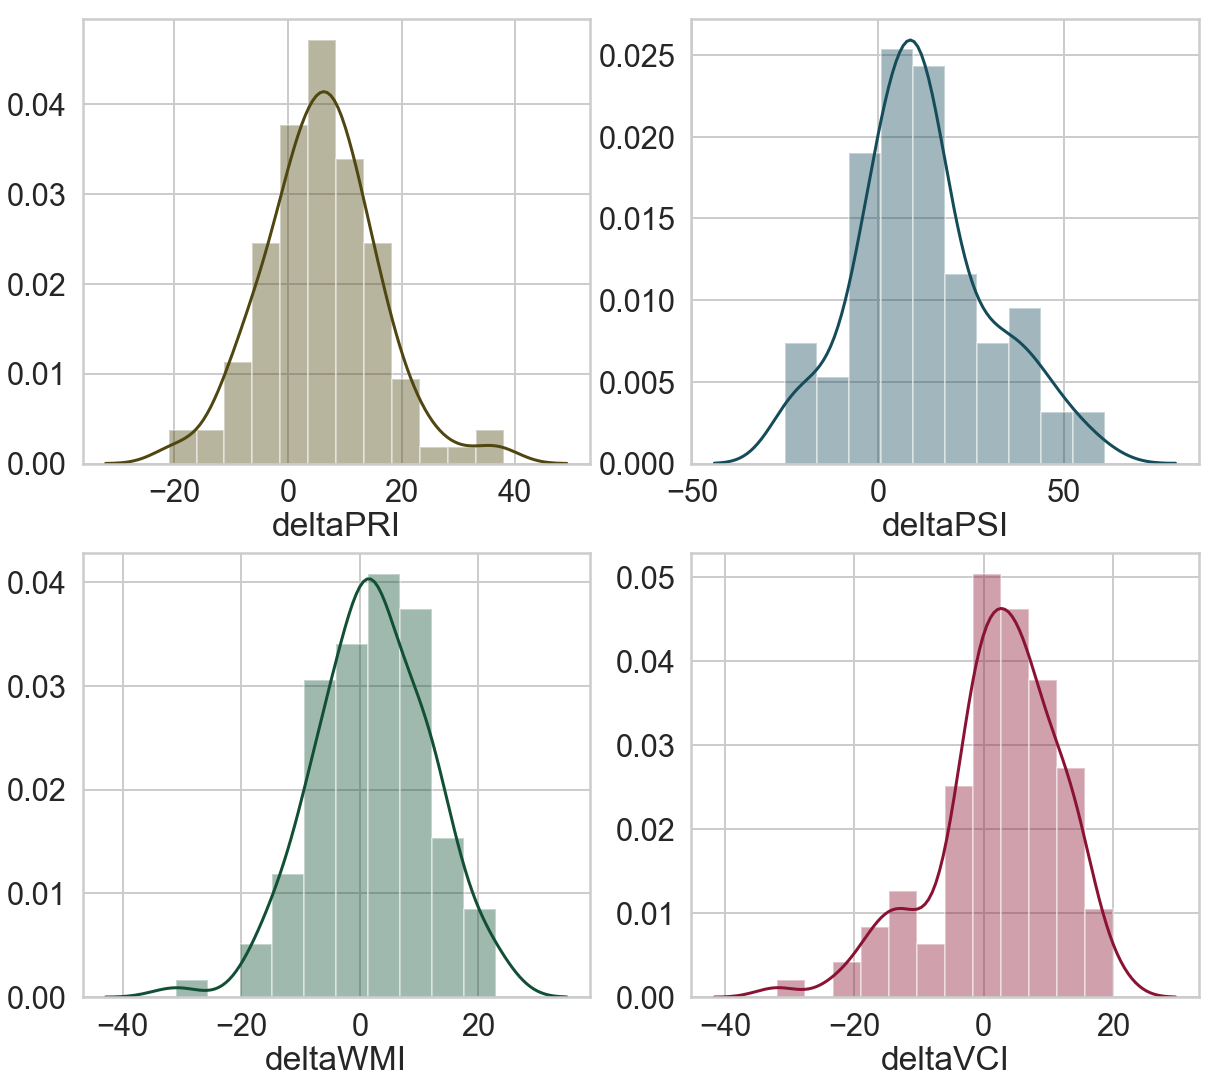

In [44]:
fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(20,18))
sns.distplot(all_df['deltaPRI'].dropna(), ax=ax[0][0], color=darker_hsl[1])
sns.distplot(all_df['deltaPSI'].dropna(), ax=ax[0][1], color=darker_hsl[3])
sns.distplot(all_df['deltaWMI'].dropna(), ax=ax[1][0], color=darker_hsl[2])
sns.distplot(all_df['deltaVCI'].dropna(), ax=ax[1][1], color=darker_hsl[0])
fig.savefig(join(fig_dir, 'SI-1_histogramspng'), dpi=300)

In [45]:
df_f = all_df[all_df['Sex'] == 'F']
df_f = df_f.drop('Sex', axis=1)
df_m = all_df[all_df['Sex'] == 'M']
df_m = df_m.drop('Sex', axis=1)

## Are there significant sex differences in IQ?

In [60]:
sessions = ['pre', 'post']
coursetype = ['All', 'Modeling', 'Lecture']
sex_diff_iq = pd.DataFrame(index=pd.MultiIndex.from_product((sessions, iqs, coursetype), 
                                                            names=['session', 'iq', 'course']),
                           columns=['t(diff)', 'p(t)', 'U', 'p(U)'])

for i in np.arange(0, len(sessions)):
    for iq in iqs:
        delta_iq = ttest_ind(df_f['{0}{1}'.format(iq, i+1)], df_m['{0}{1}'.format(iq, i+1)], nan_policy='omit')
        sex_diff_iq.at[(sessions[i],iq, 'All'), 't(diff)'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'All'), 'p(t)'] = delta_iq.pvalue
        
        delta_iq = mannwhitneyu(df_f['{0}{1}'.format(iq, i+1)], df_m['{0}{1}'.format(iq, i+1)])
        sex_diff_iq.at[(sessions[i],iq, 'All'), 'U'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'All'), 'p(U)'] = delta_iq.pvalue

        delta_iq = ttest_ind(df_f[df_f['Class.Type'] == 'Mod']['{0}{1}'.format(iq, i+1)], df_m[df_m['Class.Type'] == 'Mod']['{0}{1}'.format(iq, i+1)], nan_policy='omit')
        sex_diff_iq.at[(sessions[i],iq, 'Modeling'), 't(diff)'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'Modeling'), 'p(t)'] = delta_iq.pvalue
        
        delta_iq = mannwhitneyu(df_f[df_f['Class.Type'] == 'Mod']['{0}{1}'.format(iq, i+1)], df_m[df_m['Class.Type'] == 'Mod']['{0}{1}'.format(iq, i+1)])
        sex_diff_iq.at[(sessions[i],iq, 'Modeling'), 'U'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'Modeling'), 'p(U)'] = delta_iq.pvalue

        delta_iq = ttest_ind(df_f[df_f['Class.Type'] == 'Lec']['{0}{1}'.format(iq, i+1)], df_m[df_m['Class.Type'] == 'Lec']['{0}{1}'.format(iq, i+1)], nan_policy='omit')
        sex_diff_iq.at[(sessions[i],iq, 'Lecture'), 't(diff)'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'Lecture'), 'p(t)'] = delta_iq.pvalue
        
        delta_iq = mannwhitneyu(df_f[df_f['Class.Type'] == 'Lec']['{0}{1}'.format(iq, i+1)], df_m[df_m['Class.Type'] == 'Lec']['{0}{1}'.format(iq, i+1)])
        sex_diff_iq.at[(sessions[i],iq, 'Lecture'), 'U'] = delta_iq.statistic
        sex_diff_iq.at[(sessions[i],iq, 'Lecture'), 'p(U)'] = delta_iq.pvalue
        

In [61]:
sex_diff_iq.to_csv(join(data_dir, 'sex_differences_pre_post_iq.csv'))
sex_diff_iq

t(diff)        p(t)       U        p(U)
session iq   course                                              
pre     VCI  All         -2.62518  0.00974113  1492.5  0.00214499
             Modeling    -2.69107  0.00921391     299  0.00387335
             Lecture      -1.4054    0.164815   419.5   0.0575246
        PRI  All         -2.65208   0.0090538    1541  0.00426019
             Modeling    -1.37095    0.175584     391    0.080184
             Lecture     -2.32569    0.023321   378.5   0.0176421
        WMI  All         -1.05709    0.292524  1948.5     0.23244
             Modeling  0.00758919     0.99397     485    0.453191
             Lecture     -1.43477    0.156377     460     0.14476
        PSI  All          1.02091    0.309268    1834    0.103476
             Modeling    0.205188     0.83812     469    0.368555
             Lecture       1.1168    0.268322     441   0.0964982
        FSIQ All         -2.36704   0.0195043    1645   0.0159865
             Modeling    -1.88662   0.0641348   343.5   0.0199084
             Lecture     -1.73248   0.0882418   442.5    0.100185
post    VCI  All         -3.09793  0.00247883    1721   0.0368046
             Modeling    -3.28937  0.00173967   277.5  0.00154811
             Lecture      -1.4697    0.147786     542         0.5
        PRI  All         -3.22821  0.00164597  1744.5   0.0465442
             Modeling     -2.9538  0.00458234   312.5  0.00657765
             Lecture     -1.60775    0.114065     521    0.393532
        WMI  All         -2.27916   0.0246051    1845    0.112231
             Modeling    -1.73809   0.0876909   338.5    0.016347
             Lecture     -1.51789    0.135217   521.5    0.395658
        PSI  All         0.462161    0.644887  1895.5    0.165051
             Modeling    0.615913    0.540447   442.5    0.242389
             Lecture     0.303221    0.762955   462.5    0.153145
        FSIQ All         -3.24066  0.00158185    1740   0.0446429
             Modeling    -2.80818  0.00684593     324    0.010208
             Lecture     -1.67615   0.0998301     524    0.408479

## Significant changes in IQ pre- to post-instruction, separated by sex

In [62]:
sessions = ['pre', 'post']
coursetype = ['All', 'Mod', 'Lec', 'Difference (Lec - Mod)']
sexes = ['Female', 'Male']
sex_diff_iq = pd.DataFrame(index=pd.MultiIndex.from_product((sexes, iqs, coursetype), 
                                                            names=['Sex', 'iq', 'course']), 
                           columns=['t(diff)', 'p(t)', 'np', 'p(np)'])

for iq in iqs:
    
    delta_iq = ttest_rel(df_f['{0}2'.format(iq)], df_f['{0}1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Female',iq, 'All'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'All'), 'p(t)'] = delta_iq.pvalue

    delta_iq = ttest_rel(df_f[df_f['Class.Type'] == 'Mod']['{0}2'.format(iq)], df_f[df_f['Class.Type'] == 'Mod']['{0}1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Female',iq, 'Mod'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'Mod'), 'p(t)'] = delta_iq.pvalue

    delta_iq = ttest_rel(df_f[df_f['Class.Type'] == 'Lec']['{0}2'.format(iq)], df_f[df_f['Class.Type'] == 'Lec']['{0}1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Female',iq, 'Lec'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'Lec'), 'p(t)'] = delta_iq.pvalue
    
    
    delta_iq = wilcoxon(df_f['{0}2'.format(iq)], df_f['{0}1'.format(iq)])
    sex_diff_iq.at[('Female',iq, 'All'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'All'), 'p(np)'] = delta_iq.pvalue

    delta_iq = wilcoxon(df_f[df_f['Class.Type'] == 'Mod']['{0}2'.format(iq)], 
                        df_f[df_f['Class.Type'] == 'Mod']['{0}1'.format(iq)])
    sex_diff_iq.at[('Female',iq, 'Mod'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'Mod'), 'p(np)'] = delta_iq.pvalue

    delta_iq = wilcoxon(df_f[df_f['Class.Type'] == 'Lec']['{0}2'.format(iq)], 
                        df_f[df_f['Class.Type'] == 'Lec']['{0}1'.format(iq)])
    sex_diff_iq.at[('Female',iq, 'Lec'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Female',iq, 'Lec'), 'p(np)'] = delta_iq.pvalue
    

    delta_iq_p = ttest_ind(df_f[df_f['Class.Type'] == 'Lec']['delta{0}'.format(iq)], 
                         df_f[df_f['Class.Type'] == 'Mod']['delta{0}'.format(iq)], nan_policy='omit')
    delta_iq_np = mannwhitneyu(df_f[df_f['Class.Type'] == 'Lec']['delta{0}'.format(iq)], 
                         df_f[df_f['Class.Type'] == 'Mod']['delta{0}'.format(iq)])
   
    sex_diff_iq.at[('Female',iq, 'Difference (Lec - Mod)'), 't(diff)'] = delta_iq_p.statistic
    sex_diff_iq.at[('Female',iq, 'Difference (Lec - Mod)'), 'p(t)'] = delta_iq_p.pvalue
    
    sex_diff_iq.at[('Female',iq, 'Difference (Lec - Mod)'), 'np'] = delta_iq_np.statistic
    sex_diff_iq.at[('Female',iq, 'Difference (Lec - Mod)'), 'p(np)'] = delta_iq_np.pvalue
    
    delta_iq = ttest_rel(df_m['{0}2'.format(iq)], df_m['{0}1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Male',iq, 'All'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'All'), 'p(t)'] = delta_iq.pvalue
    
    delta_iq = wilcoxon(df_m['{0}2'.format(iq)], df_m['{0}1'.format(iq)])
    sex_diff_iq.at[('Male',iq, 'All'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'All'), 'p(np)'] = delta_iq.pvalue

    delta_iq = ttest_rel(df_m[df_m['Class.Type'] == 'Mod']['{0}2'.format(iq)], 
                         df_m[df_m['Class.Type'] == 'Mod']['{0}1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Male',iq, 'Mod'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'Mod'), 'p(t)'] = delta_iq.pvalue
    
    delta_iq = wilcoxon(df_m[df_m['Class.Type'] == 'Mod']['{0}2'.format(iq)], 
                        df_m[df_m['Class.Type'] == 'Mod']['{0}1'.format(iq)])
    sex_diff_iq.at[('Male',iq, 'Mod'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'Mod'), 'p(np)'] = delta_iq.pvalue

    delta_iq = ttest_rel(df_m[df_m['Class.Type'] == 'Lec']['{0}2'.format(iq)], 
                         df_m[df_m['Class.Type'] == 'Lec']['{0}1'.format(iq)], nan_policy='omit')
    sex_diff_iq.at[('Male',iq, 'Lec'), 't(diff)'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'Lec'), 'p(t)'] = delta_iq.pvalue
    
    delta_iq = wilcoxon(df_m[df_m['Class.Type'] == 'Lec']['{0}2'.format(iq)], 
                        df_m[df_m['Class.Type'] == 'Lec']['{0}1'.format(iq)])
    sex_diff_iq.at[('Male',iq, 'Lec'), 'np'] = delta_iq.statistic
    sex_diff_iq.at[('Male',iq, 'Lec'), 'p(np)'] = delta_iq.pvalue

    delta_iq_p = ttest_ind(df_m[df_m['Class.Type'] == 'Lec']['delta{0}'.format(iq)], 
                         df_m[df_m['Class.Type'] == 'Mod']['delta{0}'.format(iq)], nan_policy='omit')
    delta_iq_np = mannwhitneyu(df_m[df_m['Class.Type'] == 'Lec']['delta{0}'.format(iq)], 
                         df_m[df_m['Class.Type'] == 'Mod']['delta{0}'.format(iq)])
    sex_diff_iq.at[('Male',iq, 'Difference (Lec - Mod)'), 't(diff)'] = delta_iq_p.statistic
    sex_diff_iq.at[('Male',iq, 'Difference (Lec - Mod)'), 'p(t)'] = delta_iq_p.pvalue
    
    sex_diff_iq.at[('Male',iq, 'Difference (Lec - Mod)'), 'np'] = delta_iq_np.statistic
    sex_diff_iq.at[('Male',iq, 'Difference (Lec - Mod)'), 'p(np)'] = delta_iq_np.pvalue

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/morestats.py:2781: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/morestats.py:2782: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


In [63]:
sex_diff_iq

t(diff)         p(t)     np        p(np)
Sex    iq   course                                                           
Female VCI  All                      1.56709      0.12353  336.5  0.000165427
            Mod                      1.85348     0.076686     73    0.0159515
            Lec                     0.605392     0.550375   97.5   0.00316549
            Difference (Lec - Mod)  -0.62786     0.533071    382     0.144902
       PRI  All                      3.33148   0.00164879  264.5  4.67883e-06
            Mod                      2.15473    0.0418913   74.5    0.0175737
            Lec                      2.51665    0.0186323   66.5  0.000130806
            Difference (Lec - Mod)  0.552014       0.5835    336    0.0417536
       WMI  All                     0.529256     0.599067  431.5   0.00453696
            Mod                     -0.46739     0.644619   92.5     0.268813
            Lec                      1.16176     0.256757   97.5    0.0010695
            Difference (Lec - Mod)   1.15789     0.252759    299    0.0115868
       PSI  All                      4.00023  0.000213326  199.5   1.7489e-06
            Mod                      4.30018  0.000266453   20.5  0.000215439
            Lec                      1.57392     0.128078   83.5   0.00126337
            Difference (Lec - Mod)  -2.03734    0.0471491    439     0.410524
       FSIQ All                      5.23338  3.62501e-06    144  2.20745e-08
            Mod                      4.74948  8.69202e-05     17  8.89037e-05
            Lec                      2.84537   0.00893347     60  4.85034e-05
            Difference (Lec - Mod) -0.975666     0.334225  373.5     0.118541
Male   VCI  All                      1.89097    0.0635418  450.5  0.000224503
            Mod                      1.59089     0.121466  140.5   0.00423727
            Lec                      1.09668     0.282833     93     0.021014
            Difference (Lec - Mod) -0.039971     0.968254  574.5     0.432846
       PRI  All                      5.13069  3.61472e-06    223  2.78648e-08
            Mod                      4.64972    5.847e-05     52  6.15727e-06
            Lec                      2.59702    0.0155303   61.5   0.00126535
            Difference (Lec - Mod) -0.922105      0.36043  515.5     0.189077
       WMI  All                      2.52322    0.0143432    428  0.000118857
            Mod                       2.1438    0.0397492     82  0.000659313
            Lec                      1.36665     0.183437  140.5    0.0581264
            Difference (Lec - Mod) -0.417902     0.677562  527.5     0.230615
       PSI  All                      6.01215  1.23457e-07  162.5  2.70521e-09
            Mod                      5.09692  1.49911e-05     39  2.40518e-06
            Lec                        3.328   0.00261841   44.5  0.000305539
            Difference (Lec - Mod)  -1.47908     0.144531    508     0.165579
       FSIQ All                      7.41303  6.51914e-10  144.5  3.24256e-10
            Mod                      8.09161   3.8782e-09      2  1.32822e-07
            Lec                      3.30013   0.00290425   68.5  0.000432461
            Difference (Lec - Mod)  -1.40461     0.165659    526     0.225256

# Sex differences in the change in IQ

In [65]:
#sex differences (F>M) in the change in IQ

sessions = ['pre', 'post']
coursetype = ['All', 'Mod', 'Lec']
sex_diff_iq = pd.DataFrame(index=pd.MultiIndex.from_product((iqs, coursetype), 
                                                            names=['iq', 'course']), 
                           columns=['t(diff)', 'p(t)', 'np', 'p(np)'])

for iq in iqs:
    i = iq
    #both classes
    delta_iq_p = ttest_ind(df_f['delta{0}'.format(i)],
                           df_m['delta{0}'.format(i)], nan_policy='omit')
    delta_iq_np = mannwhitneyu(df_f['delta{0}'.format(i)],
                               df_m['delta{0}'.format(i)])

    sex_diff_iq.at[(iq, 'All'), 't(diff)'] = delta_iq_p.statistic
    sex_diff_iq.at[(iq, 'All'), 'p(t)'] = delta_iq_p.pvalue
    sex_diff_iq.at[(iq, 'All'), 'np'] = delta_iq_np.statistic
    sex_diff_iq.at[(iq, 'All'), 'p(np)'] = delta_iq_np.pvalue

    #Lecture
    delta_iq_p = ttest_ind(df_f[df_f['Class.Type'] == 'Lec']['delta{0}'.format(i)],
                           df_m[df_m['Class.Type'] == 'Lec']['delta{0}'.format(i)], nan_policy='omit')
    delta_iq_np = mannwhitneyu(df_f[df_f['Class.Type'] == 'Lec']['delta{0}'.format(i)],
                               df_m[df_m['Class.Type'] == 'Lec']['delta{0}'.format(i)])
    sex_diff_iq.at[(iq, 'Lec'), 't(diff)'] = delta_iq_p.statistic
    sex_diff_iq.at[(iq, 'Lec'), 'p(t)'] = delta_iq_p.pvalue
    sex_diff_iq.at[(iq, 'Lec'), 'np'] = delta_iq_np.statistic
    sex_diff_iq.at[(iq, 'Lec'), 'p(np)'] = delta_iq_np.pvalue

    #Modeling
    delta_iq_p = ttest_ind(df_f[df_f['Class.Type'] == 'Mod']['delta{0}'.format(i)],
                           df_m[df_m['Class.Type'] == 'Mod']['delta{0}'.format(i)], nan_policy='omit')
    delta_iq_np = mannwhitneyu(df_f[df_f['Class.Type'] == 'Mod']['delta{0}'.format(i)],
                               df_m[df_m['Class.Type'] == 'Mod']['delta{0}'.format(i)])

    sex_diff_iq.at[(iq, 'Mod'), 't(diff)'] = delta_iq_p.statistic
    sex_diff_iq.at[(iq, 'Mod'), 'p(t)'] = delta_iq_p.pvalue
    sex_diff_iq.at[(iq, 'Mod'), 'np'] = delta_iq_np.statistic
    sex_diff_iq.at[(iq, 'Mod'), 'p(np)'] = delta_iq_np.pvalue

In [66]:
sex_diff_iq

t(diff)       p(t)      np      p(np)
iq   course                                         
VCI  All     0.0327484   0.973936    1968   0.262685
     Mod      0.435923   0.664599   487.5   0.467282
     Lec     -0.254219   0.800349   481.5   0.218179
PRI  All      -1.04876   0.296675    2036   0.375429
     Mod      -1.57641   0.120773     352  0.0263198
     Lec     0.0254485   0.979799     463   0.154886
WMI  All      -1.31659   0.190788    2015   0.338814
     Mod      -1.76561  0.0830123   347.5  0.0226993
     Lec     -0.117448   0.906976     444    0.10375
PSI  All     -0.218518   0.827438  2043.5   0.388825
     Mod      0.504346   0.616033   485.5   0.456444
     Lec     -0.623987   0.535417   510.5   0.342708
FSIQ All      -1.14199   0.256056  1941.5   0.224055
     Mod      -1.06012   0.293807     385  0.0687894
     Lec     -0.491297    0.62541     508   0.331003

## differences in the change in IQ wrt sex and class
(the regression approach)

In [67]:
#making dummy variables for class type
class_dumb = pd.get_dummies(df_f['Class.Type'])
df_f = pd.concat((df_f, class_dumb), axis=1)

class_dumb = pd.get_dummies(df_m['Class.Type'])
df_m = pd.concat((df_m, class_dumb), axis=1)

class_dumb = pd.get_dummies(all_df['Class.Type'])
all_df = pd.concat((all_df, class_dumb), axis=1)

In [68]:
dumb = pd.get_dummies(all_df['Sex'])
all_df['F'] = dumb['F']

In [69]:
all_df['SexXClass'] = (all_df['F'] + 1) * (all_df['Mod'] + 1)

In [71]:
for iq_meas in iqs:
    df_f['{0}1XClass'.format(iq_meas)] = df_f['{0}1'.format(iq_meas)] * (df_f['Mod'] + 1)
    df_f['{0}2XClass'.format(iq_meas)] = df_f['{0}2'.format(iq_meas)] * (df_f['Mod'] + 1)
    df_m['{0}1XClass'.format(iq_meas)] = df_m['{0}1'.format(iq_meas)] * (df_m['Mod'] + 1)
    df_m['{0}2XClass'.format(iq_meas)] = df_m['{0}2'.format(iq_meas)] * (df_m['Mod'] + 1)
    all_df['{0}1XClass'.format(iq_meas)] = all_df['{0}1'.format(iq_meas)] * (all_df['Mod'] + 1)
    all_df['{0}2XClass'.format(iq_meas)] = all_df['{0}2'.format(iq_meas)] * (all_df['Mod'] + 1)

    df_f['delta{0}XClass'.format(iq_meas)] = df_f['delta{0}'.format(iq_meas)] * (df_f['Mod'] + 1)
    df_m['delta{0}XClass'.format(iq_meas)] = df_m['delta{0}'.format(iq_meas)] * (df_m['Mod'] + 1)
    all_df['delta{0}XClass'.format(iq_meas)] = all_df['delta{0}'.format(iq_meas)] * (all_df['Mod'] + 1)


In [72]:
for iq_meas in iqs:
    all_df['{0}1XClassXSex'.format(iq_meas)] = all_df['{0}1XClass'.format(iq_meas)] * (all_df['F'] + 1)
    all_df['{0}1XSex'.format(iq_meas)] = all_df['{0}1'.format(iq_meas)] * (all_df['F'] + 1)
    all_df['{0}2XClassXSex'.format(iq_meas)] = all_df['{0}1XClass'.format(iq_meas)] * (all_df['F'] + 1)
    all_df['{0}2XSex'.format(iq_meas)] = all_df['{0}1'.format(iq_meas)] * (all_df['F'] + 1)

    all_df['delta{0}XClassXSex'.format(iq_meas)] = all_df['delta{0}XClass'.format(iq_meas)] * (all_df['F'] + 1)
    all_df['delta{0}XSex'.format(iq_meas)] = all_df['delta{0}'.format(iq_meas)] * (all_df['F'] + 1)
   

In [73]:
sexes = ['Male', 'Female', 'All']


In [74]:
p_corr,_ = liji_sidak_mc(all_df, 0.05)


Number of effective comparisons: 19.92291740493446
Critical value of 0.050 becomes 0.002571 after corrections


In [75]:
#let's use regressions instead
index = pd.MultiIndex.from_product((sexes,iqs))
iqXclassXsex = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)', 
                                                     'AIC', 'BIC', 'Class_pval'])

for iq_meas in iqs:
    y = all_df['delta{0}'.format(iq_meas)]
    
    x = all_df[['Mod', 'Age', 'Strt.Level']]
    x = sm.add_constant(x)
    reg1 = sm.OLS(endog=y, 
                  exog=x, 
                  missing='drop')
    grade_on_delta_iq = reg1.fit()
    iqXclassXsex.at[('All', iq_meas), 'F-statistic'] = grade_on_delta_iq.fvalue
    iqXclassXsex.at[('All', iq_meas), 'Prob (F-statistic)'] = grade_on_delta_iq.f_pvalue
    iqXclassXsex.at[('All', iq_meas), 'AIC'] = grade_on_delta_iq.aic
    iqXclassXsex.at[('All', iq_meas), 'BIC'] = grade_on_delta_iq.bic
    iqXclassXsex.at[('All', iq_meas), 'Class_pval'] = grade_on_delta_iq.pvalues[1]
    if grade_on_delta_iq.f_pvalue < p_corr:
        print(grade_on_delta_iq.summary())
    
    y = df_m['delta{0}'.format(iq_meas)]
    
    x = df_m[['Mod', 'Age', 'Strt.Level']]
    x = sm.add_constant(x)
    reg1 = sm.OLS(endog=y, 
                  exog=x, 
                  missing='drop')
    grade_on_pre_iq = reg1.fit()
    iqXclassXsex.at[('Male', iq_meas), 'F-statistic'] = grade_on_pre_iq.fvalue
    iqXclassXsex.at[('Male', iq_meas), 'Prob (F-statistic)'] = grade_on_pre_iq.f_pvalue
    iqXclassXsex.at[('Male', iq_meas), 'AIC'] = grade_on_pre_iq.aic
    iqXclassXsex.at[('Male', iq_meas), 'BIC'] = grade_on_pre_iq.bic
    iqXclassXsex.at[('Male', iq_meas), 'Class_pval'] = grade_on_pre_iq.pvalues[1]
    if grade_on_pre_iq.f_pvalue < p_corr:
        print(grade_on_pre_iq.summary())
    
    y = df_f['delta{0}'.format(iq_meas)]
    
    x = df_f[['Mod', 'Age', 'Strt.Level']]
    x = sm.add_constant(x)
    reg1 = sm.OLS(endog=y, 
                  exog=x, 
                  missing='drop')
    grade_on_delta_iq = reg1.fit()
    iqXclassXsex.at[('Female', iq_meas), 'F-statistic'] = grade_on_delta_iq.fvalue
    iqXclassXsex.at[('Female', iq_meas), 'Prob (F-statistic)'] = grade_on_delta_iq.f_pvalue
    iqXclassXsex.at[('Female', iq_meas), 'AIC'] = grade_on_delta_iq.aic
    iqXclassXsex.at[('Female', iq_meas), 'BIC'] = grade_on_delta_iq.bic
    iqXclassXsex.at[('Female', iq_meas), 'Class_pval'] = grade_on_delta_iq.pvalues[1]
    if grade_on_delta_iq.f_pvalue < p_corr:
        print(grade_on_delta_iq.summary())
iqXclassXsex


F-statistic Prob (F-statistic)      AIC      BIC Class_pval
Male   VCI     0.326241           0.806368  432.607  440.917   0.845539
       PRI     0.916954           0.439065  429.847  438.019   0.496564
       WMI      3.30642          0.0267375  428.267  436.577    0.85874
       PSI      1.94822           0.132538  493.978  502.288   0.147666
       FSIQ     3.72766          0.0166317  390.832  399.005   0.300218
Female VCI     0.167025           0.918059  370.895  378.463   0.721018
       PRI      0.48504           0.694366  368.462   376.03   0.803344
       WMI     0.980663           0.410549  356.641  364.126   0.212856
       PSI      1.89903           0.143334  436.574  444.141  0.0436792
       FSIQ    0.717498           0.546859  338.064  345.548   0.343457
All    VCI     0.157781           0.924451  797.153  807.882    0.84132
       PRI     0.939584            0.42448  792.602  803.256   0.649302
       WMI      1.38211            0.25247  786.962  797.653   0.512828
       PSI      2.52894          0.0613296  930.554  941.283  0.0078972
       FSIQ     2.32867          0.0789666  728.141  738.757  0.0894928

In [76]:
crayons_l = sns.crayon_palette(['Vivid Tangerine', 'Cornflower'])
crayons_d = sns.crayon_palette(['Brick Red', 'Midnight Blue'])

f_2 = sns.crayon_palette(['Red Orange', 'Vivid Tangerine'])
m_2 = sns.crayon_palette(['Cornflower', 'Cerulean'])

f = sns.diverging_palette(8.2, 44, s=85, l=50, n=200)
m = sns.diverging_palette(243, 278, s=85, l=50, n=200)


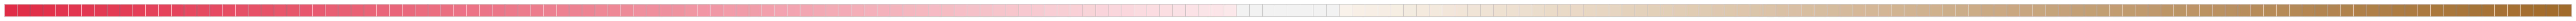

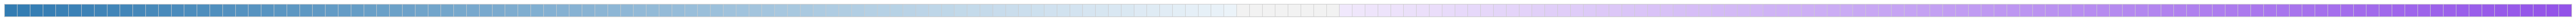

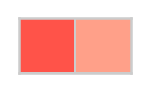

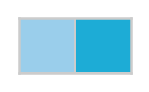

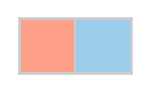

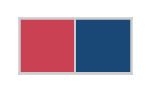

In [77]:
sns.palplot(f)
sns.palplot(m)

sns.palplot(f_2)
sns.palplot(m_2)

sns.palplot(crayons_l)
sns.palplot(crayons_d)

In [78]:
corrfonty = {'fontsize': 10,
             'fontweight': 'regular',
             'verticalalignment': 'center',
             'horizontalalignment': 'right'}
corrfontx = {'fontsize': 10,
             'fontweight': 'regular',
             'verticalalignment': 'top',
             'horizontalalignment': 'center'}

In [79]:
fs_long.head()


,Sex,Subject,Class.Type,Session,Full Scale IQ,IQ
0,F,101,Lec,Pre,94.0,Full Scale IQ
1,M,102,Mod,Pre,104.0,Full Scale IQ
2,M,103,Lec,Pre,98.0,Full Scale IQ
3,F,104,Mod,Pre,103.0,Full Scale IQ
4,M,105,Lec,Pre,110.0,Full Scale IQ


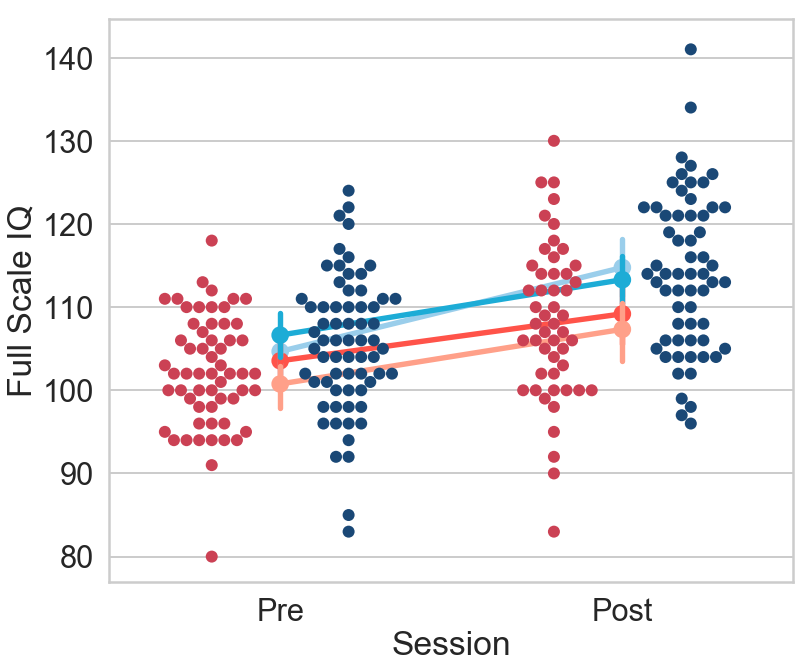

In [80]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
plt.tight_layout(pad=5)
mksz = 12
k = sns.swarmplot(x='Session', y='Full Scale IQ', hue='Sex', data=fs_long, palette=crayons_d, dodge=True, ax=ax, size=mksz)
k.get_legend().set_visible(False)

j = sns.pointplot(x='Session', y='Full Scale IQ', hue='Class.Type', data=fs_long[fs_long['Sex'] == 'M'], ax=ax, palette=m_2)
j = sns.pointplot(x='Session', y='Full Scale IQ', hue='Class.Type', data=fs_long[fs_long['Sex'] == 'F'], ax=ax, palette=f_2)
j.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-IQ+SCALEDpng', dpi=300)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
plt.tight_layout(pad=5)
mksz = 10
k = sns.pointplot(x='Session', y='Verbal Comprehension', hue='Sex', data=vc_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Verbal Comprehension', hue='Sex', data=vc_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-vcIQpng', dpi=300)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
plt.tight_layout(pad=5)
mksz = 10
k = sns.pointplot(x='Session', y='Perceptual Reasoning', hue='Sex', data=pr_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Perceptual Reasoning', hue='Sex', data=pr_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-prIQpng', dpi=300)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
plt.tight_layout(pad=5)
mksz = 10
k = sns.pointplot(x='Session', y='Working Memory', hue='Sex', data=wm_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Working Memory', hue='Sex', data=wm_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-wmIQpng', dpi=300)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7.5))
mksz = 10
plt.tight_layout(pad=5)
k = sns.pointplot(x='Session', y='Processing Speed', hue='Sex', data=ps_long, palette=crayons_d, ax=ax, size=mksz)
k.get_legend().set_visible(False)
g = sns.swarmplot(x='Session', y='Processing Speed', hue='Sex', data=ps_long, 
              palette=crayons_d, ax=ax, size=mksz, dodge=True)
g.get_legend().set_visible(False)
fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-psIQpng', dpi=300)

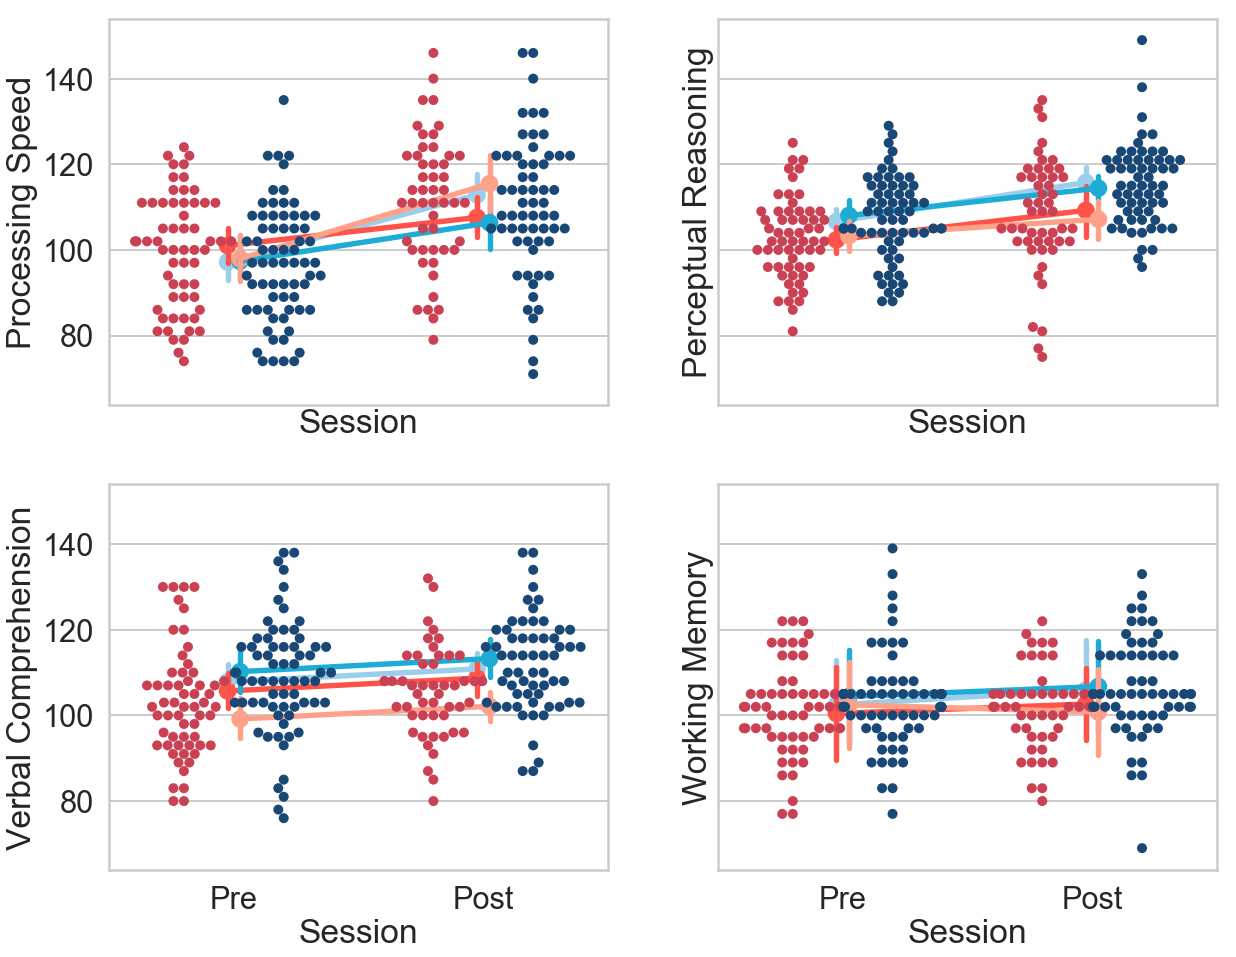

In [83]:
fig,ax = plt.subplots(ncols=2, nrows=2, figsize=(18, 14), sharex=True, sharey=True, squeeze=True)
mksz = 10
plt.tight_layout(pad=5)

h = sns.pointplot(x='Session', y='Perceptual Reasoning', hue='Class.Type', data=pr_long[pr_long['Sex'] == 'M'], 
              palette=m_2, ax=ax[0][1], size=mksz, dodge=True)
h = sns.pointplot(x='Session', y='Perceptual Reasoning', hue='Class.Type', data=pr_long[pr_long['Sex'] == 'F'], 
              palette=f_2, ax=ax[0][1], size=mksz, dodge=True)
h.get_legend().set_visible(False)


i = sns.pointplot(x='Session', y='Processing Speed', hue='Class.Type', data=ps_long[ps_long['Sex'] == 'M'], 
              palette=m_2, ax=ax[0][0], size=mksz, dodge=True)
i = sns.pointplot(x='Session', y='Processing Speed', hue='Class.Type', data=ps_long[ps_long['Sex'] == 'F'], 
              palette=f_2, ax=ax[0][0], size=mksz, dodge=True)
i.get_legend().set_visible(False)

j = sns.pointplot(x='Session', y='Verbal Comprehension', hue='Class.Type', data=vc_long[vc_long['Sex'] == 'M'], 
              palette=m_2, ax=ax[1][0], size=mksz, dodge=True)
j = sns.pointplot(x='Session', y='Verbal Comprehension', hue='Class.Type', data=vc_long[vc_long['Sex'] == 'F'], 
              palette=f_2, ax=ax[1][0], size=mksz, dodge=True)
j.get_legend().set_visible(False)

k = sns.pointplot(x='Session', y='Working Memory', hue='Class.Type', data=wm_long[wm_long['Sex'] == 'M'], 
              palette=m_2, ax=ax[1][1], size=mksz, dodge=True, ci='sd')
k = sns.pointplot(x='Session', y='Working Memory', hue='Class.Type', data=wm_long[wm_long['Sex'] == 'F'], 
              palette=f_2, ax=ax[1][1], size=mksz, dodge=True, ci='sd')
k.get_legend().set_visible(False)


h = sns.swarmplot(x='Session', y='Perceptual Reasoning', hue='Sex', data=pr_long, 
              palette=crayons_d, ax=ax[0][1], size=mksz, dodge=True)
h.get_legend().set_visible(False)
i = sns.swarmplot(x='Session', y='Working Memory', hue='Sex', data=wm_long, 
              palette=crayons_d, ax=ax[1][1], size=mksz, dodge=True)
i.get_legend().set_visible(False)
j = sns.swarmplot(x='Session', y='Processing Speed', hue='Sex', data=ps_long, 
              palette=crayons_d, ax=ax[0][0], size=mksz, dodge=True)
j.get_legend().set_visible(False)
k = sns.swarmplot(x='Session', y='Verbal Comprehension', hue='Sex', data=vc_long, 
              palette=crayons_d, ax=ax[1][0], size=mksz, dodge=True)
k.get_legend().set_visible(False)


fig.savefig('/Users/Katie/Dropbox/Projects/physics-retrieval/figures/figure1_change-IQ-subscores+SCALEDpng', dpi=300)


## Does IQ facilitate learning?
Is pre-instruction IQ significantly related to academic performance or change in physics knowledge/reasoning?

## Does IQ reflect learning?
Is the change in IQ over the duration of the course related to academic performance or change in physics knowledge/reasoning?

In [49]:
sessions.append('delta')

In [50]:
mc_alpha,_ = liji_sidak_mc(all_df, 0.05)

Number of effective comparisons: 20.151056075593527
Critical value of 0.050 becomes 0.002542 after corrections


In [51]:
#is there a difference in accuracy/performance between classes?
print(ttest_ind(all_df[all_df['Mod'] == 1]['Phy48Grade'], 
                all_df[all_df['Mod'] == 0]['Phy48Grade'], nan_policy='omit'))
print(ttest_ind(all_df[all_df['Mod'] == 1]['RetrPhyAcc2'], 
                all_df[all_df['Mod'] == 0]['RetrPhyAcc2'], nan_policy='omit'))
print(ttest_ind(all_df[all_df['Mod'] == 1]['FCIPhyAcc2'], 
                all_df[all_df['Mod'] == 0]['FCIPhyAcc2'], nan_policy='omit'))

Ttest_indResult(statistic=2.0284372468128855, pvalue=0.045047103515521124)
Ttest_indResult(statistic=-1.3426921337937392, pvalue=0.18223993929085225)
Ttest_indResult(statistic=-0.7980942965062702, pvalue=0.42660015307583676)


In [94]:
grade = pd.read_csv(join(data_dir, 'iq+brain+demo.csv'), index_col=0, header=0, usecols=['ID', 'Phy48Grade'])

In [96]:
all_df = pd.concat([all_df, grade], axis=1)

In [97]:
outcomes = ['Phy48Grade', 'RetrPhyAcc2', 'FCIPhyAcc2', 
            'deltaRetrPhyAcc', 'deltaFCIPhyAcc']
covariates = ['Age', 'Mod', 'Strt.Level', 'F']


In [98]:
index = pd.MultiIndex.from_product((sessions, iqs))
perf_iqXclassXsex = pd.DataFrame(index=index, columns=['F-statistic', 'Prob (F-statistic)',
                                                        'AIC', 'BIC', 'IQ_pval', 'IQXClass_pval', 
                                                        'IQXClass_pval', 'SexXClass_pval', 'IQXSex_pval', 
                                                        'IQXClassXSex_pval'])
for outcome in outcomes:
    for iq_meas in iqs:
        y = all_df[outcome]
        x = all_df[['{0}1'.format(iq_meas), 
                    '{0}1XClass'.format(iq_meas), 
                    'SexXClass',
                    '{0}1XSex'.format(iq_meas),
                    '{0}1XClassXSex'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        perf_on_pre_iq = reg1.fit()
        perf_iqXclassXsex.loc[('pre', iq_meas), 'F-statistic'] = perf_on_pre_iq.fvalue
        perf_iqXclassXsex.loc[('pre', iq_meas), 'Prob (F-statistic)'] = perf_on_pre_iq.f_pvalue
        perf_iqXclassXsex.loc[('pre', iq_meas), 'AIC'] = perf_on_pre_iq.aic
        perf_iqXclassXsex.loc[('pre', iq_meas), 'BIC'] = perf_on_pre_iq.bic
        perf_iqXclassXsex.loc[('pre', iq_meas), 'IQ_pval'] = perf_on_pre_iq.pvalues[1] 
        perf_iqXclassXsex.loc[('pre', iq_meas), 'IQXClass_pval'] = perf_on_pre_iq.pvalues[2]
        perf_iqXclassXsex.loc[('pre', iq_meas), 'SexXClass_pval'] = perf_on_pre_iq.pvalues[3]
        perf_iqXclassXsex.loc[('pre', iq_meas), 'IQXSex_pval'] = perf_on_pre_iq.pvalues[4]
        perf_iqXclassXsex.loc[('pre', iq_meas), 'IQXClassXSex_pval'] = perf_on_pre_iq.pvalues[5]
        #print('Course grade regressed on pre IQ, female students\n', grade_on_iq.summary())
        
        if perf_on_pre_iq.f_pvalue < mc_alpha:
            print(perf_on_pre_iq.summary())

        x = all_df[['{0}2'.format(iq_meas), 
                    '{0}2XClass'.format(iq_meas), 
                    'SexXClass',
                    '{0}2XSex'.format(iq_meas),
                    '{0}2XClassXSex'.format(iq_meas)] + covariates]
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        perf_on_post_iq = reg1.fit()
        perf_iqXclassXsex.loc[('post', iq_meas), 'F-statistic'] = perf_on_post_iq.fvalue
        perf_iqXclassXsex.loc[('post', iq_meas), 'Prob (F-statistic)'] = perf_on_post_iq.f_pvalue
        perf_iqXclassXsex.loc[('post', iq_meas), 'AIC'] = perf_on_post_iq.aic
        perf_iqXclassXsex.loc[('post', iq_meas), 'BIC'] = perf_on_post_iq.bic
        perf_iqXclassXsex.loc[('post', iq_meas), 'IQ_pval'] = perf_on_post_iq.pvalues[1] 
        perf_iqXclassXsex.loc[('post', iq_meas), 'IQXClass_pval'] = perf_on_post_iq.pvalues[2]
        perf_iqXclassXsex.loc[('post', iq_meas), 'SexXClass_pval'] = perf_on_post_iq.pvalues[3]
        perf_iqXclassXsex.loc[('post', iq_meas), 'IQXSex_pval'] = perf_on_post_iq.pvalues[4]
        perf_iqXclassXsex.loc[('post', iq_meas), 'IQXClassXSex_pval'] = perf_on_post_iq.pvalues[5]
        #print('Course grade regressed on post IQ, female students\n', grade_on_iq.summary())

        
        if perf_on_post_iq.f_pvalue < mc_alpha:
            print(perf_on_post_iq.summary())
            
        x = all_df[['delta{0}'.format(iq_meas), 
                    'delta{0}XClass'.format(iq_meas), 
                    'SexXClass', 
                    'delta{0}XSex'.format(iq_meas),
                    'delta{0}XClassXSex'.format(iq_meas)] + covariates]
        
        x = sm.add_constant(x)
        reg1 = sm.OLS(endog=y, 
                      exog=x, 
                      missing='drop')
        perf_on_delta_iq = reg1.fit()
        perf_iqXclassXsex.loc[('delta', iq_meas), 'F-statistic'] = perf_on_delta_iq.fvalue
        perf_iqXclassXsex.loc[('delta', iq_meas), 'Prob (F-statistic)'] = perf_on_delta_iq.f_pvalue
        perf_iqXclassXsex.loc[('delta', iq_meas), 'AIC'] = perf_on_delta_iq.aic
        perf_iqXclassXsex.loc[('delta', iq_meas), 'BIC'] = perf_on_delta_iq.bic
        perf_iqXclassXsex.loc[('delta', iq_meas), 'IQ_pval'] = perf_on_delta_iq.pvalues[1]
        perf_iqXclassXsex.loc[('delta', iq_meas), 'IQXClass_pval'] = perf_on_delta_iq.pvalues[2]
        perf_iqXclassXsex.loc[('delta', iq_meas), 'SexXClass_pval'] = perf_on_delta_iq.pvalues[3]
        perf_iqXclassXsex.loc[('delta', iq_meas), 'IQXSex_pval'] = perf_on_delta_iq.pvalues[4]
        perf_iqXclassXsex.loc[('delta', iq_meas), 'IQXClassXSex_pval'] = perf_on_delta_iq.pvalues[3]

        
        if perf_on_delta_iq.f_pvalue < mc_alpha:
            print(perf_on_delta_iq.summary())
    perf_iqXclassXsex.to_csv(join(data_dir, 'iqX{0}Xsex_all.csv'.format(outcome)))

                            OLS Regression Results                            
Dep. Variable:            RetrPhyAcc2   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     5.061
Date:                Sat, 19 Oct 2019   Prob (F-statistic):           1.41e-05
Time:                        17:04:56   Log-Likelihood:                 99.206
No. Observations:                 105   AIC:                            -178.4
Df Residuals:                      95   BIC:                            -151.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2497      0.318      0.

In [99]:
f_2 = sns.crayon_palette(['Red Orange', 'Vivid Tangerine'])
m_2 = sns.crayon_palette(['Cerulean', 'Cornflower'])


<Figure size 432x288 with 0 Axes>

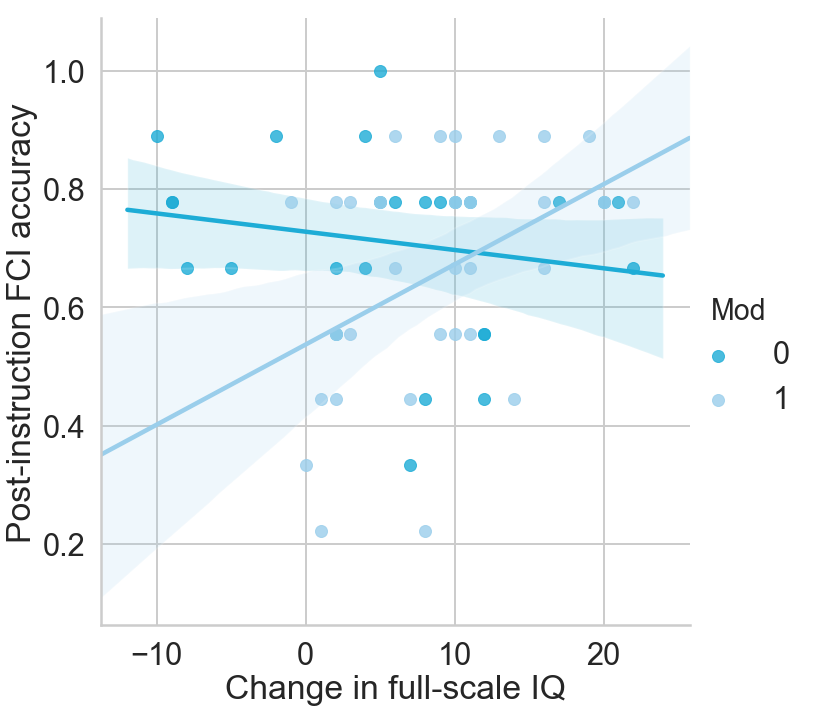

In [101]:
plt.tight_layout(pad=5)
g = sns.lmplot('deltaFSIQ', 'FCIPhyAcc2', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10., )
#g.set_yticklabels(['10', '7.5', '5.0', '2.5', '0.0', '-2.5', '-5.0', '-7.5', '-10'])
g.set_xlabels('Change in full-scale IQ')
g.set_ylabels('Post-instruction FCI accuracy')
g.savefig(join(fig_dir, 'delta_fsiqXpost_fci_acc-mpng'), dpi=300)

<Figure size 432x288 with 0 Axes>

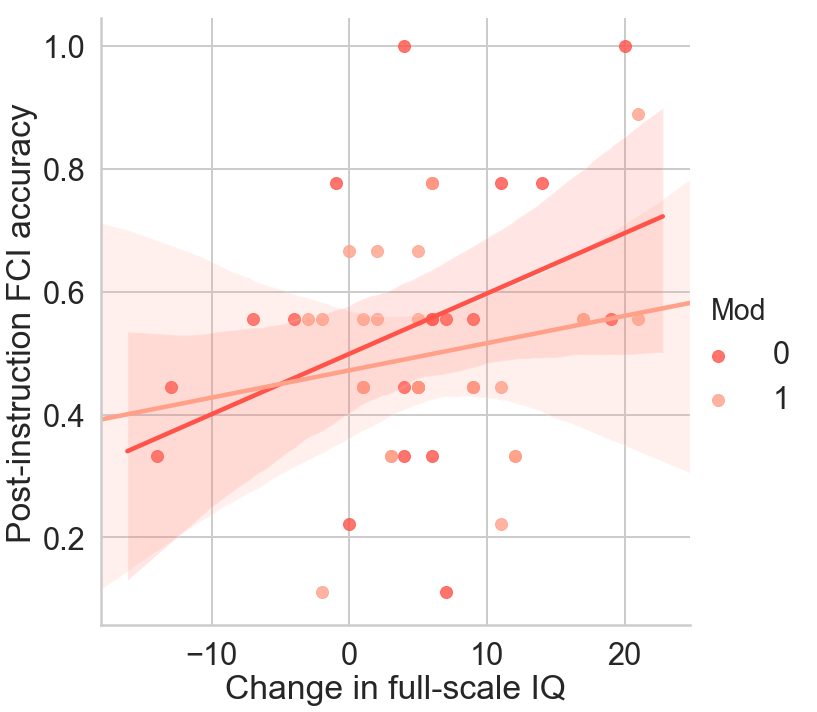

In [102]:
plt.tight_layout(pad=5)
g = sns.lmplot('deltaFSIQ', 'FCIPhyAcc2', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)
#g.set_yticklabels(['10', '7.5', '5.0', '2.5', '0.0', '-2.5', '-5.0', '-7.5', '-10'])
g.set_xlabels('Change in full-scale IQ')
g.set_ylabels('Post-instruction FCI accuracy')
g.savefig(join(fig_dir, 'delta_fsiqXpost_fci_acc-fpng'), dpi=300)

In [57]:
df_f.index.shape

(61,)

In [58]:
df_m.index.shape

(69,)

In [59]:
float(df_m.index.shape[0]) + float(df_f.index.shape[0])

130.0

<Figure size 432x288 with 0 Axes>

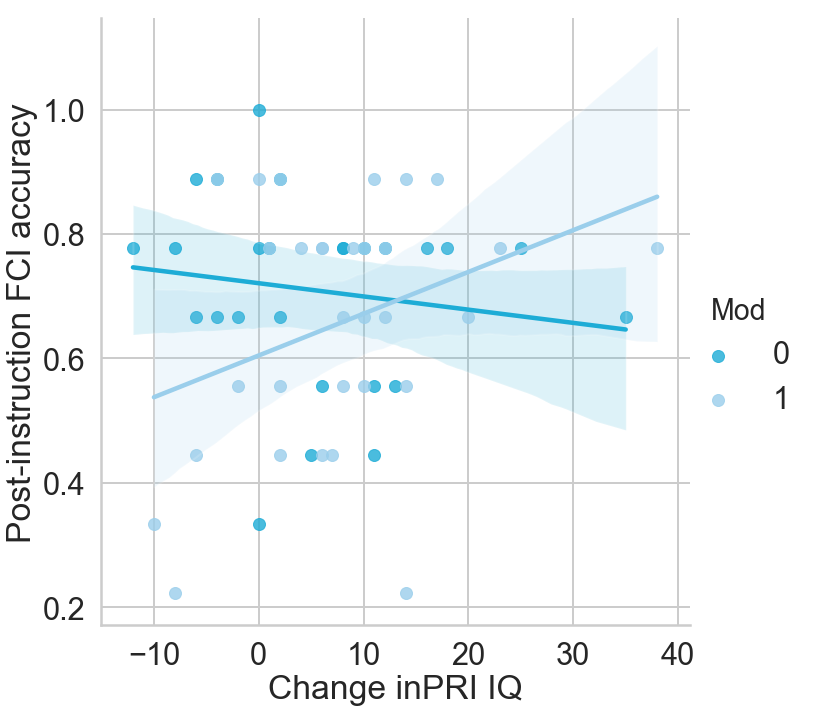

In [103]:
plt.tight_layout(pad=5)
g = sns.lmplot('deltaPRI', 'FCIPhyAcc2', data=df_m, hue='Mod', 
           palette=m_2, legend_out=True, height=10., truncate=True)
#g.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1.0'])
g.set_xlabels('Change inPRI IQ')
g.set_ylabels('Post-instruction FCI accuracy')
g.savefig(join(fig_dir, 'delta_priqXpost_fci_acc-mpng'), dpi=300)

<Figure size 432x288 with 0 Axes>

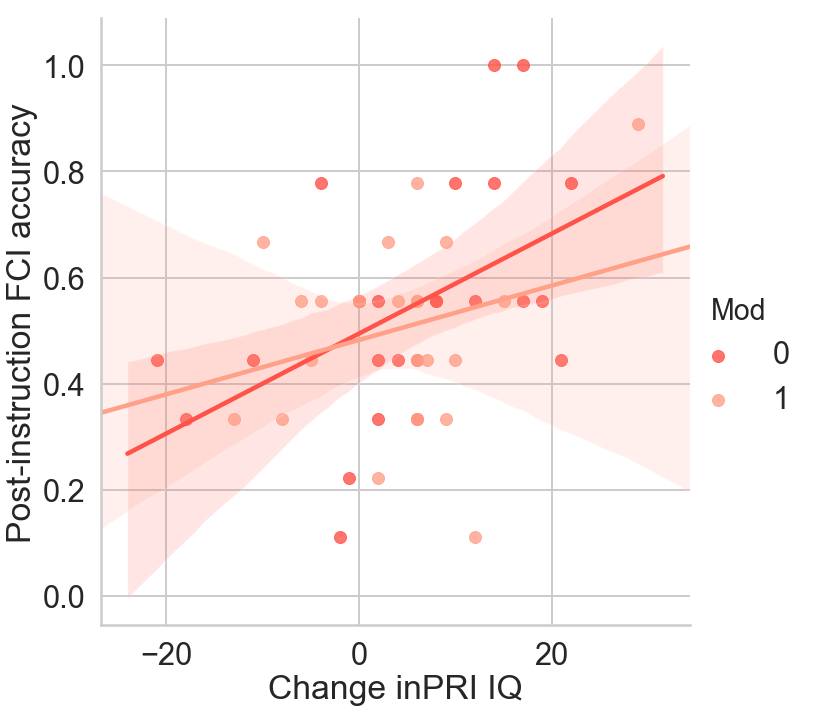

In [104]:
plt.tight_layout(pad=5)
g = sns.lmplot('deltaPRI', 'FCIPhyAcc2', data=df_f, hue='Mod', 
           palette=f_2, legend_out=True, height=10.)
#g.set_yticklabels(['10', '7.5', '5.0', '2.5', '0.0', '-2.5', '-5.0', '-7.5', '-10'])
g.set_xlabels('Change inPRI IQ')
g.set_ylabels('Post-instruction FCI accuracy')
g.savefig(join(fig_dir, 'delta_priqXpost_fci_acc-fpng'), dpi=300)